## Introduction to Object-Oriented Programming (OOP) in Data Analysis

### Overview of Object-Oriented Programming (OOP)
Object-oriented programming (OOP) is a programming paradigm based on the concept of "objects," which can contain data in the form of fields (attributes or properties) and code in the form of procedures (methods or functions). OOP is particularly useful in managing complexity in large software systems by breaking down functionalities into manageable, modular, and reusable components.

### Why Use OOP in This Code
1. **Modularity**: The encapsulation of functionality within classes makes the code more organized and modular, simplifying maintenance and scalability.
2. **Reusability**: OOP allows for the code to be reused across different parts of the project and in future projects. Once a class is created, it can be instantiated multiple times without rewriting code.
3. **Scalability**: Enhancements and modifications can be easily managed by adding new classes or modifying existing ones without impacting other parts of the code, accommodating evolving experimental setups and analysis methods.

### Summary of How This Code Works
- **Initialization**: Instances of the `DataFile` class are created for each dataset. Each instance manages the data from a specific file, incorporating attributes and methods tailored to processing that data.
- **Data Handling**: The `DataFile` class includes methods to read data, preprocess it, and extract key parameters like voltage, current, temperature, and resistance, preparing it for detailed analysis.
- **Data Analysis**:
  - **Graphing Methods**: Methods such as `graph_log_r_vs_1_over_temp_by_voltage`, `graph_special_power_vs_temp`, and `graph_voltage_vs_temp_type` visualize relationships between different physical properties.
  - **Utility Functions**: Functions to find specific data points or conditions, enabling targeted and detailed analysis of the dataset.
- **Execution Flow**: Each `DataFile` object executes methods systematically to analyze the data consistently across different datasets and conditions.

This introduction sets the stage for the detailed data analyses within the notebook, helping users navigate through the code with an understanding of the structural and methodological choices made.


In [325]:
%matplotlib inline
%config InlineBackend.figure_format='svg'
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
import os
from scipy.stats import linregress
# import chain

from operator import attrgetter
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from itertools import chain

from os.path import isfile, join

# if this is true, figures will be saved to your computer
saveFigures = True

# set size and dpi of figures
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 600
# plt.rcParams['figure.dpi'] = 300

### Function Descriptions for Data Analysis

#### Trend Analysis Functions
- `is_increasing(L)`: Determines if a list `L` is strictly increasing. This is true if the first element is less than the last and the list contains more than one element.
- `is_decreasing(L)`: Determines if a list `L` is strictly decreasing. This is true if the first element is greater than the last and the list contains more than one element.
- `non_increasing(L)`: Checks if a list `L` never increases; i.e., each element is less than or equal to the next.
- `non_decreasing(L)`: Checks if a list `L` never decreases; i.e., each element is greater than or equal to the next.
- `monotonic(L)`: Determines if a list `L` is either entirely non-increasing or non-decreasing.

#### Utility Functions
- `average(array)`: Computes the average of values in the given `array`.

#### Data Classification Function
- `sort_into_side(voltage, current)`: Classifies a paired data set of voltages and currents into categories based on their trends:
  - "posThresh" if both voltage and current are increasing.
  - "posHold" if both voltage and current are decreasing.
  - "negThresh" if voltage decreases and current increases.
  - "negHold" if voltage increases and current decreases.
  - Prints an error message if the data type cannot be determined.

#### Random ID Generator
- `get_rand_id()`: Generates a random integer ID between 0 and 999999999.

#### Closest Number Finder
- `find_index_of_closest_number_in_list(float_list, number)`: Finds the index of the number in `float_list` that is closest to the specified `number`.

#### Percentage Threshold Checker
- `is_within_percentage_threshold(number, reference, percentage)`: Determines whether `number` is within a specified `percentage` threshold of `reference`.


In [326]:

# these functions are used in determining the type
# of data we are looking at (posthresh, neghold etc)
def is_increasing(L):
    return L[0] < L[len(L) - 1] and len(L) > 1
def is_decreasing(L):
    return L[0] > L[len(L) - 1] and len(L) > 1
def non_increasing(L):
    return all(x>=y for x, y in zip(L, L[1:]))
def non_decreasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))
def monotonic(L):
    return non_increasing(L) or non_decreasing(L)
def average(array):
    return sum(array) / len(array)

# this will return the type of data you give it
# it takes an array of [voltages] and [currents] as arguments
def sort_into_side(voltage, current):
    if is_increasing(voltage) and is_increasing(current):
        return "posThresh"
    elif is_decreasing(voltage) and is_decreasing(current):
        return "posHold"
    elif is_decreasing(voltage) and is_increasing(current):
        return "negThresh"
    elif is_increasing(voltage) and is_decreasing(current):
        return "negHold"
    else: 
        print("error determining type of data. V: ", voltage, " I: ", current)

def get_rand_id():
    return np.random.randint(1000000000)

def find_index_of_closest_number_in_list(float_list, number):
    closest_index = 0  # Initialize with the index of the first value in the list
    closest_difference = abs(float_list[0] - number)  # Initialize with the absolute difference

    for i in range(1, len(float_list)):
        difference = abs(float_list[i] - number)
        if difference < closest_difference:
            closest_index = i
            closest_difference = difference

    return closest_index

def is_within_percentage_threshold(number, reference, percentage):
    # Calculate the allowable range based on the reference and percentage
    allowable_range = reference * (percentage / 100)
    # Check if the number is within the allowable range
    return abs(number - reference) <= allowable_range



### Graph Class Explanation

#### Class Definition:
- The `Graph` class is designed to facilitate the creation and visualization of various types of graphs based on scientific data. It includes functionality to handle multiple plot types and annotations like horizontal lines and custom points.

#### Constructor `__init__`:
- `title`: Sets the title of the graph.
- `xlabel`: Label for the x-axis.
- `ylabel`: Label for the y-axis.
- `hlines`: A list of y-values where horizontal lines should be drawn.
- `type_of_graph`: Specifies the type of graph ('multiPlot', 'box', 'semilogy', 'semilogx', 'loglog', 'plot').
- `data_to_graph`: A nested list containing the data pairs (x and y values) to be plotted.
- `points`: Specific points to highlight on the graph.
- `legends`: Legends corresponding to each dataset.
- Initializes a color pool for line plotting and invokes the `show()` method to generate the graph.

#### Method `show`:
- Sets up the figure and axes for plotting.
- Handles various types of plots specified by `type_of_graph`:
  - **multiPlot**: Supports plotting multiple y-axes.
  - **box**: Creates a boxplot.
  - **semilogy**: Plots data on a semi-logarithmic y-axis.
  - **semilogx**: Plots data on a semi-logarithmic x-axis.
  - **loglog**: Plots data on a logarithmic scale for both axes.
  - **plot**: Standard plot.
- Additional features:
  - Configures twin axes if needed.
  - Applies grid, sets limits and font sizes for better readability.
  - Manages plot labels and colors dynamically from the `color_pool`.
  - Handles legends and axis labels.
  - Uses control structures to adapt to data specifics like reversing data sequences if required.
  - Horizontal lines and custom point markers are added based on the `hlines` and `points` attributes.
  - An auxiliary x-axis can be added for alternative scale representations (e.g., temperature conversion).

#### Usage Note:
- This class is equipped to handle detailed customization and is suitable for scientific data visualization where multiple plot adjustments and specific data annotations are required.
- Ensure that the data inputs (`data_to_graph`, `hlines`, `points`) are correctly formatted to avoid runtime errors and to ensure plots are drawn as expected.



In [327]:
class Graph: 
    def __init__(self, title, xlabel, ylabel, hlines, type_of_graph, data_to_graph, points, legends):
        self.title = title
        self.xlabel = xlabel
        self.ylabel = ylabel
        self.hlines = hlines
        self.type = type_of_graph
        self.data_to_graph = data_to_graph
        self.points = points
        self.legends = legends


        self.color_pool = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink', 'olive', 'purple', 'gray', 'orange', 'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink', 'olive', 'purple', 'gray', 'orange','blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink', 'olive', 'purple', 'gray', 'orange', 'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink', 'olive', 'purple', 'gray', 'orange', 'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink', 'olive', 'purple', 'gray', 'orange', 'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink', 'olive', 'purple', 'gray', 'orange','blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink', 'olive', 'purple', 'gray', 'orange', 'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink', 'olive', 'purple', 'gray', 'orange', 'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink', 'olive', 'purple', 'gray', 'orange', 'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink', 'olive', 'purple', 'gray', 'orange','blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink', 'olive', 'purple', 'gray', 'orange', 'blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'brown', 'pink', 'olive', 'purple', 'gray', 'orange' ]
        self.color_pool = [ 
            '#0000ff', '#0000ff', '#0000ff', '#0000ff', 
            '#1c00e2', '#1c00e2', '#1c00e2', '#1c00e2', 
            '#3800c6', '#3800c6', '#3800c6', '#3800c6', 
            '#5500aa', '#5500aa', '#5500aa', '#5500aa', 
            '#71008d', '#71008d', '#71008d', '#71008d', 
            '#8d0071', '#8d0071', '#8d0071', '#8d0071', 
            '#aa0055', '#aa0055', '#aa0055', '#aa0055', 
            '#c60038', '#c60038', '#c60038', '#c60038', 
            '#e2001c', '#e2001c', '#e2001c', '#e2001c', 
            '#ff0000', '#ff0000', '#ff0000', '#ff0000', 
            
            # '#ff0000', '#ff0000', '#ff0000', '#ff0000', 
            # # '#e2001c', '#e2001c', '#e2001c', '#e2001c', 
            # '#c60038', '#c60038', '#c60038', '#c60038', 
            # # '#aa0055', '#aa0055', '#aa0055', '#aa0055', 
            # '#8d0071', '#8d0071', '#8d0071', '#8d0071', 
            # # '#71008d', '#71008d', '#71008d', '#71008d', 
            # '#5500aa', '#5500aa', '#5500aa', '#5500aa', 
            # # '#3800c6', '#3800c6', '#3800c6', '#3800c6', 
            # '#1c00e2', '#1c00e2', '#1c00e2', '#1c00e2', 
            # # '#0000ff', '#0000ff', '#0000ff', '#0000ff', 
   '#0000ff', '#0000ff', '#00ff00', 'red', 'red', 'red', 'red', 'red', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue',  'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue',  'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', ]
        self.show()

    def show(self):
        
        fig, ax = plt.subplots()
        
        if self.type == "multiPlot":
            plt.xlabel(self.xlabel)
            plt.ylabel(self.ylabel)
            ax2 = ax.twinx()
            
        plt.title(self.title)
        plt.xlabel(self.xlabel, fontsize=14)
        plt.ylabel(self.ylabel, fontsize=14)
        plt.rcParams['font.size'] = 14  # Adjust the font size as needed
        # plt.xlim(0, 300)
        # plt.ylim(5, 20)
        ax.grid()

  


        if self.type == "box":
            # print(self.data_to_graph)
            ax.boxplot(self.data_to_graph, labels=self.points)
        else:
            for i in range(len(self.data_to_graph) - 0):
                x = self.data_to_graph[i][0]
                y = self.data_to_graph[i][1]

                if x[0] > x[1] and "lnR vs 1000/T voltage" in self.title:
                    x = np.flip(x)
                    y = np.flip(y)

                color = self.color_pool[i]
                if self.type == "semilogy":
                    if len(self.legends) > 1:
                        print("self.legends: ", self.legends)
                        if i < 10: 
                            print("self.legends[" , i, "]: ", self.legends[i])
                        print("data_to_graph: ", self.data_to_graph[i])
                        print("i: ", i)
                        # print("y: ", y)
        
                        ax.semilogy(x, y, color=color, label=self.legends, linewidth=4)
                        # rectangle = patches.Rectangle((5, 1000), 1.66666, 1000000, linewidth=1, edgecolor='red', facecolor='none')
                        # ax.add_patch(rectangle)


                        my_array_size = 5

                        x_fits_beginning = np.array(x[:my_array_size])
                        y_fits_beginning = np.array(y[:my_array_size])
                        # x_fits_end = np.array(x[-my_array_size:])
                        # y_fits_end = np.array(y[-my_array_size:])

                        # energy_level = ""
                        # slope, intercept, r_value, p_value, std_err = linregress(x_fits_end, y_fits_end)
                        # Ea = 1000 * slope * (0.000086)
                        # energy_level = "E_a: " + str(round(Ea, 3)) + " - "
                        # my_legend = self.legends[i] + energy_level
                        # line_of_best_fit_end = (slope * x_fits_end) + intercept

                        energy_level = ""
                        slope, intercept, r_value, p_value, std_err = linregress(x_fits_beginning, y_fits_beginning)
                        Ea = 1000 * slope * (0.000086)
                        energy_level = str(round(Ea, 3)) + " eV"
                        # my_legend = ""
                        my_legend = "y = " + str(slope) + "x" + str(intercept)
                        line_of_best_fit = (slope * x_fits_beginning) + intercept
                        ax.plot(x_fits_beginning, line_of_best_fit, color='red', linewidth=2 )

                        
                    else:
                        ax.semilogy(x, y, color=color, linewidth=4)

                elif self.type == "semilogx":
                    if len(self.legends) > 0:
                        ax.semilogx(x, y, color=color, label=self.legends)
                    else:
                        ax.semilogx(x, y, color=color)
                elif self.type == "loglog":
                    if len(self.legends) > 0:
                        ax.loglog(x, y, color=color, label=self.legends)
                    else:
                        ax.loglog(x, y, color=color)
                elif self.type == "multiPlot" and len(x) > 1:
                    ax.plot(x, y, color='blue', label=self.legends) 
                    

                    x2 = self.data_to_graph[i][3]
                    y2 = self.data_to_graph[i][4]

                    # print("x2, y2: ", x2, y2)

                    # print("0: ", y2[0])
                    # print("1: ", y2[1])
                    # print("2: ", y2[2])
                    # print("3: ", y2[3])
                    # print("4: ", y2[4])


                    # color = 'tab:red'
                    ax2.set_ylabel('max I - V', color="tab:red")
                    ax2.plot(x2, y2, color="red")
                    ax2.tick_params(axis='y', labelcolor="red")

                    # data_to_graph = [[t_posThresh, p_posThresh, " ", temperature_1, conductivity_1], [t_negThresh, np.abs(p_negThresh), " ", temperature_2, conductivity_2]]




                elif self.type == "plot" and len(x) > 1: 

                    # ax.plot(x, y, color=color)

                    # array_size = (int)(len(x) * 0.1)

                    # if array_size < 10:
                        # array_size = 10
                    
                    # my_array_size = 10

                    # x_fits_beginning = np.array(x[:my_array_size])
                    # y_fits_beginning = np.array(y[:my_array_size])
                    # x_fits_end = np.array(x[-my_array_size:])
                    # y_fits_end = np.array(y[-my_array_size:])

                    # energy_level = ""
                    # slope, intercept, r_value, p_value, std_err = linregress(x_fits_end, y_fits_end)
                    # Ea = 1000 * slope * (0.000086)
                    # energy_level = "E_a: " + str(round(Ea, 3)) + " - "
                    # my_legend = self.legends[i] + energy_level
                    # line_of_best_fit_end = (slope * x_fits_end) + intercept

                    # energy_level = ""
                    # slope, intercept, r_value, p_value, std_err = linregress(x_fits_beginning, y_fits_beginning)
                    # Ea = 1000 * slope * (0.000086)
                    # energy_level = str(round(Ea, 3)) + " eV"
                    # # my_legend = ""
                    # my_legend = my_legend + energy_level
                    # line_of_best_fit = (slope * x_fits_beginning) + intercept



                    
                    

                    try: 
                        ax.plot(x, y, color=color, label=self.legends[i], linewidth=4)   
                        ax.legend(loc='upper left')

                        if "lnR vs 1000/T voltage" in self.title and i == 1:
                            print("self.data_to_graph[i][0]: ", self.data_to_graph[i][0])
                            # rectangle = patches.Rectangle((5, 10), 1.66666, 2, linewidth=1, edgecolor='red', facecolor='none')
                            # ax.add_patch(rectangle)


                            index = next((i for i, num in enumerate(x) if num > 5), None)
                            my_array_size = index

                            x_fits_beginning = np.array(x[:my_array_size])
                            y_fits_beginning = np.array(y[:my_array_size])


                            energy_level = ""
                            slope, intercept, r_value, p_value, std_err = linregress(x_fits_beginning, y_fits_beginning)
                            Ea = 1000 * slope * (0.000086)
                            energy_level = str(round(Ea, 3)) + " eV"
                            print("activation energy: ", energy_level)

                            # # my_legend = ""
                            my_legend = "y = " + str(slope) + "x +" + str(intercept)
                            line_of_best_fit = (slope * x) + intercept
                            ax.plot(x, line_of_best_fit, color='red', label=energy_level, linewidth=2,)

                        
                    except Exception as e:
                        # Code to handle other exceptions
                        ax.plot(x, y, color=color)   


                    # ax.plot(x_fits_beginning, line_of_best_fit, color='red', linewidth=2)
                    # ax.plot(x_fits_end, line_of_best_fit_end, color='green', linewidth=2)
                    
                        
                        
                    
                elif self.type == "box":
                    ax.boxplot(x, y, color=color)
                    # ax.boxplot(x, y, color=color, label=self.legends[i])
                
                # ax.legend(loc="upper right", title="Legend Title")
            
                    
            for i in range(len(self.hlines)):
                ax.axhline(y = self.hlines[i], color = 'r', linestyle = '-')

            for i in range(len(self.points)):
                color_to_use = "red"
                # if self.points[i][2] == "posHold": 
                #     color_to_use = "blue"
                # if self.points[i][2] == "negThresh": 
                #     color_to_use = "green"
                # if self.points[i][2] == "negHold": 
                #     color_to_use = "orange"

                ax.plot(self.points[i][0], self.points[i][1], marker="o", markersize=10, markeredgecolor=color_to_use, markerfacecolor=color_to_use)
  
        











        ### used for temp ticks and label at the top
        # ax2 = ax.twiny()

        # new_tick_locations = np.array([4, 6, 8, 10, 12, 14, 16, 18])

        # def tick_function(X):
        #     V = 1000 / X
        #     return ["%.0f" % z for z in V]

        # ax2.set_xlim(ax.get_xlim())
        # ax2.set_xticks(new_tick_locations)
        # ax2.set_xticklabels(tick_function(new_tick_locations))
        # ax2.set_xlabel('Temperature (K)')

        

        
        if saveFigures: 
            plt.savefig('figures/forPaper/' + self.title[:25] + '.png', bbox_inches='tight')
        plt.figure(get_rand_id())
        plt.show()

    # def fit_to_line(self):
    #     print("fdsa")

### Function Descriptions for Data Analysis

#### Data Filtering and Processing Functions

- `read_file_data(data)`:
  - **Purpose**: Reads experimental data from a file, excluding any rows where the current is near its maximum, as these may represent measurement errors or anomalies.
  - **Process**:
    - Reads the file twice: once to identify rows with currents near the maximum and again to exclude those rows.
    - Uses a cutoff value for current set at 99.99999% of the highest recorded current to determine which rows to exclude.
    - Returns the filtered data as a NumPy array for further processing.

- `createDataDictionary(data, start, stop)`:
  - **Purpose**: Creates a dictionary of data metrics for a specified range from `start` to `stop` within the dataset.
  - **Details**:
    - Calculates the first and second derivatives of the current (`dI` and `ddI`).
    - Computes average and standard deviation of temperature over the range.
    - Computes power (`P`) as the product of current and voltage.
    - Determines the type of data using `sort_into_side` based on voltage and current characteristics.
    - Returns a dictionary containing time, current, resistance, voltage, power, temperature metrics, derivatives of current, and type classification.

#### Data Analysis Functions

- `count_IV_curves(data)`:
  - **Purpose**: Counts how many of each type of IV curve (`posThresh`, `negThresh`, `posHold`, `negHold`) are present in the dataset.
  - **Process**:
    - Iterates through a list of IV curves, incrementing counters based on the type of each curve.
    - Returns a list containing counts for each type of curve.

#### Utility Functions for Finding Specific Regions in Data

- `find_regions_values_less_than_threshold(data, threshold)`:
  - **Purpose**: Identifies contiguous regions in `data` where values fall below a specified `threshold`.
  - **Process**:
    - Iterates through the data, collecting values into regions as long as they remain below the threshold.
    - Once a value exceeds the threshold, the current region is saved and a new region starts.
    - Returns a list of regions.

- `find_regions_indices_less_than_threshold(data, threshold)`:
  - **Purpose**: Similar to `find_regions_values_less_than_threshold`, but returns indices of the data points instead of the values.
  - **Process**:
    - Useful for later referencing these regions in the original data array.

- `find_regions_and_average(data, threshold)`:
  - **Purpose**: Finds regions where data values are below a `threshold` and also calculates the average of values within each region.
  - **Process**:
    - Not only identifies the regions but also computes their average, storing each region and its average in a dictionary.
    - Useful for statistical analyses where the average of sub-threshold regions is needed.

These functions form the core of a data analysis pipeline designed to preprocess, analyze, and categorize large datasets. Their modular design allows for easy adaptation and extension according to specific research needs.


In [328]:
def read_file_data(data):
    # REMOVE BAD DATA: read all the data and remove the rows when we are very close to the max current
    rows_to_exclude = pd.read_csv(data.filePath, names=['Time (s)','Current (A)','Voltage (V)', 'Temperature (K)'], sep='\t',skiprows=1)
    data_from_file = rows_to_exclude.values
    rows_to_exclude.head()
    I_to_skip = data_from_file[:,1]
    # the cut off value for the max current is 0.9999999 * the highest current recorded in the file
    max_current = np.max(I_to_skip) * 0.9999999
    over_max_current_indexes = ((I_to_skip > max_current).nonzero())[0]
    # read the file again without the rows that have a current above the threshold
    df5 = pd.read_csv(data.filePath, names=['Time (s)','Current (A)','Voltage (V)', 'Temperature (K)'], sep='\t',skiprows=over_max_current_indexes)
    return df5.values

# takes the data and 
def createDataDictionary(data, start, stop):
    dI = np.gradient(data.I[start:stop])
    ddI = np.gradient(np.gradient(data.I[start:stop]))
    run_temp = np.average(data.temps[start:stop])
    run_temp_std = np.std(data.temps[start:stop])
    return {
        'time': data.time[start:stop],
        'I': data.I[start:stop],
        'R': data.R[start:stop],
        'dI': dI,
        'ddI': ddI,
        'V': data.V[start:stop],
        'P': data.I.copy()[start:stop] * data.V.copy()[start:stop],
        'temps': data.temps[start:stop],
        'temp': run_temp,
        'temp_std': run_temp_std,
        'type_of_data': sort_into_side(data.V[start:stop], data.I[start:stop]),
        'max_ddI': np.argmax(ddI),
    }

# counts how many posThresh, negThresh, posHold, or negHold data sets there are
def count_IV_curves(data):
    pos_thresh_IV_curve_count = 0
    pos_hold_IV_curve_count = 0
    neg_thresh_IV_curve_count = 0
    neg_hold_IV_curve_count = 0
    for IV_curve in data.IV_curves:
        if IV_curve['type_of_data'] == "posThresh":
            pos_thresh_IV_curve_count += 1
        if IV_curve['type_of_data'] == "negThresh":
            neg_thresh_IV_curve_count += 1
        if IV_curve['type_of_data'] == "posHold":
            pos_hold_IV_curve_count += 1
        if IV_curve['type_of_data'] == "negHold":
            neg_hold_IV_curve_count += 1
    return [pos_thresh_IV_curve_count, pos_hold_IV_curve_count, neg_thresh_IV_curve_count, neg_hold_IV_curve_count]


def find_regions_values_less_than_threshold(data, threshold):
    regions = []
    current_region = []

    for i, value in enumerate(data):
        if value < threshold:
            current_region.append(value)
        elif current_region:
            regions.append(current_region)
            current_region = []

    if current_region:
        regions.append(current_region)

    return regions


def find_regions_indices_less_than_threshold(data, threshold):
    regions = []
    current_region = []

    for i, value in enumerate(data):
        if value < threshold and value > -threshold:
            current_region.append(i)
        elif current_region:
            regions.append(current_region)
            current_region = []

    if current_region:
        regions.append(current_region)

    return regions


def find_regions_and_average(data, threshold):
    regions = []
    current_region = []

    for i, value in enumerate(data):
        if value < threshold:
            current_region.append(value)
        elif current_region:
            regions.append({
                'values': current_region,
                'average': np.mean(current_region)
            })
            current_region = []

    if current_region:
        regions.append({
            'values': current_region,
            'average': np.mean(current_region)
        })

    return regions

### DataFile Class Explanation

#### Constructor `__init__`:
- **Purpose**: Initializes a new instance of the `DataFile` class by setting up key properties and initiating data processing functions.
- **Details**:
  - `file_path`: Path to the data file.
  - Extracts meaningful components from the file such as file name, device number, sample number, and reads all the data.
  - Processes the data to break it into IV curve segments and calculates temperature ranges.
  - Handles exceptions during data processing, printing error messages if any issues arise.

#### Data Processing Methods:
- `get_file_name_from_path()`: Extracts the file name from the file path for easier reference within the class.
- `get_device_number_from_name()`: Isolates the device number from the file name, typically used for organizing or categorizing data.
- `get_sample_number_from_name()`: Extracts the sample number from the file name, useful for tracking and analysis purposes.
- `read_all_data()`: Reads the complete dataset from the file, filters out data points where the current is at or above a certain threshold (to remove noise or faulty readings), and calculates resistance as voltage divided by current.

#### Graphing and Analysis Functions:
- `graph_all_data()`: Plots all filtered data on a semilogarithmic graph to visualize the relationship between voltage and current across the entire dataset.
- `break_all_data_into_IV_curves()`: Segments the complete data into individual IV curves based on zero crossings in the voltage data, further splitting these into positive and negative sweep data.
- `get_temp_range()`: Determines the temperature range over the course of the data collection from the segmented IV curves.
- `count_IV_curve_types()`: Counts how many of each type of IV curve (`posThresh`, `negThresh`, `posHold`, `negHold`) are present, useful for statistical and comparative analyses.

#### Utility Functions for Graphing:
- `get_IV_curve_data(index)`: Prepares data for graphing a specific IV curve by identifying key points like V_thresh and V_hold based on the type of data and its characteristics.
- `graph_IV_curve(index)`: Utilizes the `Graph` class to plot an individual IV curve at a specific index with annotations.
- `graph_IV_curves(number_of_graphs)`: Facilitates the graphing of multiple IV curves, spread out across the dataset to provide a broad overview.
- `overlay_IV_curves(number_of_graphs)`: Overlays multiple IV curves on a single graph, adjusted by temperature to provide comparative insights at different conditions.

#### Data Utility Functions:
- `get_IV_curve_data_by_temp(temp)`: Fetches IV curve data closest to a specified temperature, aiding in targeted analysis under specific thermal conditions.




### Method: `graph_voltage_vs_resistance_half_volt`
**Purpose**: This method is designed to graph the percentage difference in resistance at voltages close to 0.5 volts. It is particularly useful for examining the resistance variability near this specific voltage threshold, which can be critical for certain types of electrical or material analyses.

**Process**:
1. **Data Filtering**: The method iterates through all recorded voltages, selecting those that are approximately 0.5 volts within a tolerance of 5%. This tolerance accounts for potential data variability or noise.
2. **Resistance Difference Calculation**: For each selected voltage point, the resistance at that point and the immediate next point are used to calculate the percentage difference in resistance.
3. **Graphing**: The percentage differences are then plotted against the corresponding temperatures for both positive and negative voltages. This dual plot provides insights into the resistance behavior under slight voltage variations around 0.5 volts.
4. **Visualization**: Utilizes the `Graph` class to create and display the plot, facilitating an easy-to-understand visual representation of the data.

### Method: `graph_lowest_voltage_resistance`
**Purpose**: This method graphs the percentage difference in resistance at the lowest non-zero voltages observed in the dataset. It aims to analyze the resistance characteristics at minimal electrical stress, which can be pivotal for studying material or device properties.

**Process**:
1. **Zero Voltage Identification**: The method identifies instances where the voltage is exactly zero and then examines the resistance at the nearest non-zero voltages both before and after these points.
2. **Percentage Difference Calculation**: Calculates the percentage differences in resistance between these points to determine how resistance changes as the voltage moves away from zero.
3. **Graphing**: Plots these percentage differences against the corresponding temperatures for both directions of voltage change (increasing and decreasing), which helps in understanding how the material or device responds to minimal voltage applications.
4. **Visualization**: Employs the `Graph` class for plotting, ensuring that the results are presented in a clear and interpretable format.




### Method: `graph_log_r_vs_1_over_temp_by_voltage`
**Purpose**: This method is designed to graph the natural logarithm of resistance (`ln(R)`) against the reciprocal of temperature (`1000/T`) at specific voltage values. It helps in examining the temperature-dependent resistance behavior of the device at distinct operational voltages.

**Process**:
1. **Voltage Selection**: The method focuses on plotting data for specified voltages (e.g., 0.4 V, 0.03 V). These voltages are chosen based on their relevance to the experimental conditions or the device's operational characteristics.
2. **Data Extraction**: For each selected voltage:
    - It identifies the closest voltage point in the dataset using `find_index_of_closest_number_in_list`.
    - Checks if this voltage is within a 40% threshold of the desired voltage to accommodate data variability.
3. **Resistance and Temperature Calculation**:
    - The resistance at these points is converted to its natural logarithm.
    - Temperature is converted to `1000/T` to reflect an Arrhenius-type relationship, commonly used in materials science to analyze thermal activation processes.
4. **Graphing**:
    - Plots `ln(R)` against `1000/T` for the selected voltages.
    - This plot can help visualize changes in resistance with temperature at a constant voltage, providing insights into thermal stability or the activation energy required for electronic conduction.
5. **Visualization**:
    - Utilizes the `Graph` class to create the plot, ensuring clear and informative visualization.
    - Labels each plot line with the corresponding voltage value for easy identification.


In [329]:
# this will take a file name and
# get all of the meaningful stuff out of it
class DataFile:
    def __init__(self, file_path):
        self.filePath = file_path # path to the data file
        self.get_file_name_from_path() # takes the path and isolates the file name
        self.get_device_number_from_name() # reads the device number from the filename
        self.get_sample_number_from_name() # reads the sample number from the filename
        self.read_all_data() # reads all the data and saves it
        try:
            self.break_all_data_into_IV_curves()
            self.get_temp_range()
        except Exception as e:
            # Code to handle other exceptions
            print(f"An error occurred: {e} ", self.file_name)
        # self.count_IV_curve_types()

    def get_file_name_from_path(self):
        self.file_name = self.filePath.split("summerData/")[1]
        # print(self.file_name)

    def get_device_number_from_name(self):
        self.device_number = self.file_name.split("_")[4]

    def get_sample_number_from_name(self):
        self.sample_number = self.file_name.split("_")[3]

    # reads all the data using the filename and saves each
    def read_all_data(self):

        data = read_file_data(self)
        indices_greater_than_01 = [index for index, value in enumerate(data[:,1]) if value >= 0.01]
        
        interval = 1
        # time = np.arange(0, len(data[:,0])) * interval

        time = data[:,0]
        current = data[:,1]
        voltage = data[:,2]
        temps = data[:,3]

        self.time = np.array([time[i] for i in range(len(time)) if i not in indices_greater_than_01])
        self.I = np.array([current[i] for i in range(len(current)) if i not in indices_greater_than_01])
        self.V = np.array([voltage[i] for i in range(len(voltage)) if i not in indices_greater_than_01])
        self.temps = np.array([temps[i] for i in range(len(temps)) if i not in indices_greater_than_01])
        self.R = self.V / self.I

        self.number_of_data_points = len(data[:,0])
        
    # make IV graph of all data
    def graph_all_data(self):
        fig, ax = plt.subplots()
        plt.title("All Data")
        plt.xlabel("Voltage (V)")
        plt.ylabel("Current (A)")
        ax.grid()
        ax.semilogy(self.V, self.I, color='black')

    # takes all the data and breaks it into segments. Each segment is a posThresh, negThresh, posHold, negHold
    def break_all_data_into_IV_curves(self):
        # get the index of every "0.000" value in the voltage array
        self.all_zero_indexes = np.where(self.V == 0.0)[0]

        # removing the first and last 4 "0.000" data points reduces the number of crashes
        self.all_zero_indexes = self.all_zero_indexes[4:]
        self.all_zero_indexes = self.all_zero_indexes[:-4]

        # the data between two "0.000" points will be stored here as a list
        self.IV_curves = []

        # gets the following data out of the file: 'I' 'R' 'dI' 'ddI' 'V' 'temps' 'temp' 'temp_std' 'type_of_data' 'max_ddI' and stores it in a dictionary
        # the positive and negative voltage data will be stored in separate dictionary enteries
        for i in range(len(self.all_zero_indexes) - 1):
            start = self.all_zero_indexes[i] # where to start the list
            stop = (int)(start + ((self.all_zero_indexes[i+1] - start) / 2)) # where to end the list. This is the first half of the data which is the positive side
            self.IV_curves.append(createDataDictionary(self, start, stop))

            start = (int)(self.all_zero_indexes[i] + ((self.all_zero_indexes[i+1] - start) / 2)) # where to start the list. Second half of the data
            stop = self.all_zero_indexes[i+1] # where to end the list
            self.IV_curves.append(createDataDictionary(self, start, stop))

        # counts the number of total IV curves in the data
        self.number_of_IV_curves = (len(self.IV_curves) - 1) * 1

    # gets the temp range of the data
    def get_temp_range(self):
        # store all temperature data 
        all_temps = []
        for i in range(0, self.number_of_IV_curves):
            temp = self.IV_curves[i]['temp']
            all_temps.append(temp)
        self.all_temps = all_temps

        # store the temperature range in all the data
        min_temp = all_temps[5] 
        max_temp = all_temps[len(all_temps) - 5 ]
        self.temp_range = [min_temp, max_temp]

    # counts the number of each type of IV curves in the data
    def count_IV_curve_types(self):
        iv_curve_types = count_IV_curves(self)
        print("pos_thresh_IV_curve_count: ", iv_curve_types[0])
        print("pos_hold_IV_curve_count: ", iv_curve_types[1])
        print("neg_thresh_IV_curve_count: ", iv_curve_types[2])
        print("neg_hold_IV_curve_count: ", iv_curve_types[3])

    # gets data for graph of IV curves with dots at V_thresh and V_hold
    def get_IV_curve_data(self, index):
        
        # this is where the IV data, V_thresh and V_hold will be stored
        data_to_graph = []
        points_to_graph = []

        # combine 4 "IV" curves to make one full period of a voltage sweep
        for i in range(4):
            voltage = self.IV_curves[index + i]['V']
            current = self.IV_curves[index + i]['I']
            data_to_graph.append([voltage, current])

            # depending on the direction of the voltage sweep, make slight asjustments to find the V_thresh and V_hold
            fine_tune = 0
            type_of_data = self.IV_curves[index + i]['type_of_data']
            if type_of_data == "posThresh":
                fine_tune = 1
            if type_of_data == "negThresh":
                fine_tune = 1
            if type_of_data == "posHold":
                fine_tune = -2
            if type_of_data == "negHold":
                fine_tune = -2
            
            index_to_graph = self.IV_curves[index + i]['max_ddI'] + fine_tune # index of V_thresh or V_hold for the given IV_curve
            points_to_graph.append([voltage[index_to_graph], current[index_to_graph], type_of_data])

        # graph title
        title =  self.file_name.split("23_")[1][:-4] + " " + str(index) + "_" + str((self.number_of_IV_curves))
    
        return [
            title,              # title
            "Voltage (V)",      # xlabel
            "Current (A)",      # ylabel
            [],                 # hlines
            "semilogy",         # type of graph
            data_to_graph,      # data to graph
            points_to_graph,    # points
            [],                 #legends
        ]
    
    # gets IV curve data at a certain temperature
    def get_IV_curve_data_by_temp(self, temp):
        
        # this is where the IV data, V_thresh and V_hold will be stored
        data_to_graph = []
        points_to_graph = []

        # find the clostest temperature in the data to the one I want to graph
        index = find_index_of_closest_number_in_list(self.all_temps[0:-5], temp)

        # combine 4 "IV" curves to make one full period of a voltage sweep
        for i in range(4):
            voltage = self.IV_curves[index + i]['V']
            current = self.IV_curves[index + i]['I']
            data_to_graph.append([voltage, current])

            fine_tune = 0
            type_of_data = self.IV_curves[index + i]['type_of_data']
            if type_of_data == "posThresh":
                fine_tune = 1
            if type_of_data == "negThresh":
                fine_tune = 1
            if type_of_data == "posHold":
                fine_tune = -2
            if type_of_data == "negHold":
                fine_tune = -2
            
            index_to_graph = self.IV_curves[index + i]['max_ddI'] + fine_tune # index of V_thresh or V_hold for the given IV_curve
            points_to_graph.append([voltage[index_to_graph], current[index_to_graph], type_of_data])

        # graph title
        title_temp = str(round(self.IV_curves[index]['temp'])) + "K "
        title = "IVcurve_" + str(index) + title_temp

        return [
            title_temp,              # title
            "Voltage (V)",      # xlabel
            "Current (A)",      # ylabel
            [],                 # hlines
            "semilogy",         # type of graph
            data_to_graph,      # data to graph
            points_to_graph,    # points
            [],                 #legends
        ]

    # uses the function that I defined above to graph an IV curve with the V_hold and V_thresh points
    def graph_IV_curve(self, index):
        ic_curve_data = self.get_IV_curve_data(index)
        the_graph = Graph(
            ic_curve_data[0],   # title
            ic_curve_data[1],   # xlabel
            ic_curve_data[2],   # ylabel
            ic_curve_data[3],   # hlines
            ic_curve_data[4],   # type of graph
            ic_curve_data[5],   # data to graph
            ic_curve_data[6],   # points
            ic_curve_data[7],   #legends
        )

    # make multiple IV curve on separate graphs
    def graph_IV_curves(self, number_of_graphs):
        for x in range(0, number_of_graphs):
            i = (int)(((self.number_of_IV_curves) / number_of_graphs) * x)
            self.graph_IV_curve(i)

    # stacks multiple IV curves on the same graph. they are evenly spaced by temperature
    def overlay_IV_curves(self, number_of_graphs):

        min_temp = self.temp_range[0]
        max_temp = self.temp_range[1]
        temp_step = (max_temp - min_temp) / (number_of_graphs) # temperature spacing between each graph

        # store all the data in iv_curves
        iv_curves = []
        temp_to_graph = min_temp
        for x in range(0, number_of_graphs):
            iv_curves.append(self.get_IV_curve_data_by_temp(temp_to_graph))
            temp_to_graph = temp_to_graph + temp_step

        # set up the graph
        title = "Sam " + self.file_name.split("_Sam")[1][:-4]
        data_to_graph = []
        legends = []
        points = []
        for i in range(0, len(iv_curves)):
            title = title + iv_curves[i][0]
            data_to_graph += iv_curves[i][5]
            # points += iv_curves[i][6]
            legends.append(iv_curves[i][0])

        xlabel = iv_curves[0][1]
        ylabel = iv_curves[0][2]
        hlines = iv_curves[0][3]
        type_of_graph = iv_curves[0][4]
        # data_to_graph = iv_curves[0][5] + iv_curves[1][5] + iv_curves[2][5] + iv_curves[3][5] + iv_curves[4][5]
        # points = iv_curves[0][6] + iv_curves[1][6] + iv_curves[2][6] + iv_curves[3][6] + iv_curves[4][6]
        # legends = [iv_curves[0][0], iv_curves[1][0], iv_curves[2][0], iv_curves[3][0], iv_curves[4][0]]

        # make the graph
        the_graph = Graph(
            title,
            xlabel,
            ylabel,
            hlines,
            type_of_graph,
            data_to_graph,
            points,
            legends,
        )

    # make graph of percent diff resistance at 0.5 V
    def graph_voltage_vs_resistance_half_volt(self):
        data_to_graph = []

        lowest_voltage_resistance = []
        second_lowest_voltage_resistance = []

        neg_lowest_voltage_resistance = []
        neg_second_lowest_voltage_resistance = []

        # store them as easily readable names
        currents = self.I
        voltages = self.V
        resistances = self.R
        temps = self.temps

        # go through all voltages and save the resistance and temp when the voltage is close to 0.5 V
        for index in range(len(self.V)):
            
            if is_within_percentage_threshold(voltages[index], 0.5, 5) or is_within_percentage_threshold(-1 * voltages[index], 0.5, 5): # 5% tolerance on voltage values because the data can be noisy
                if index + 2 < len(voltages) and index - 2 > 0:
                    if voltages[index] > 0:
                        lowest_voltage_resistance.append([temps[index], voltages[index], resistances[index]])
                        second_lowest_voltage_resistance.append([temps[index + 1], voltages[index + 1], resistances[index + 1]])

                    if voltages[index] < 0:
                        neg_lowest_voltage_resistance.append([temps[index], voltages[index], resistances[index]])
                        neg_second_lowest_voltage_resistance.append([temps[index - 1], voltages[index - 1], resistances[index - 1]])

        
        xAxis = []
        yAxis = []

        xAxis2 = []
        yAxis2 = []

        for index in range(len(lowest_voltage_resistance)):
            temp1 = lowest_voltage_resistance[index][0]
            temp2 = second_lowest_voltage_resistance[index][0]

            resistance1 = lowest_voltage_resistance[index][2]
            resistance2 = second_lowest_voltage_resistance[index][2]

            percent_diff = abs((resistance1 - resistance2) / ((resistance1 + resistance2) / 2)) * 100

            # if index > 50:
            xAxis.append(temp1)
            yAxis.append(percent_diff)

        for index in range(len(neg_lowest_voltage_resistance)):
            temp1 = neg_lowest_voltage_resistance[index][0]
            temp2 = neg_second_lowest_voltage_resistance[index][0]

            resistance1 = neg_lowest_voltage_resistance[index][2]
            resistance2 = neg_second_lowest_voltage_resistance[index][2]

            percent_diff = abs((resistance1 - resistance2) / ((resistance1 + resistance2) / 2)) * 100

            # if index > 50:
            xAxis2.append(temp1)
            yAxis2.append(percent_diff)

        data_to_graph = [[xAxis, yAxis], [xAxis2, yAxis2]]
        legends = ["pos", "neg"]




        # print("lowest_voltage_resistance: ", lowest_voltage_resistance)
        # print("second_lowest_voltage_resistance: ", second_lowest_voltage_resistance)
        # print("neg_lowest_voltage_resistance: ", neg_lowest_voltage_resistance)
        # print("neg_second_lowest_voltage_resistance: ", neg_second_lowest_voltage_resistance)
        # print("data_to_graph: ", data_to_graph)
        
        the_graph = Graph(
        self.file_name[19:-4] +  " percent diff resistance half volt",   # title
        "Temp (K)",                             # xlabel
        "percent diff",                          # ylabel
        [],                                     # hlines
        "plot",                             # type of graph
        data_to_graph,                          # data to graph
        [],                                     # points
        legends                                  # legends
        )






    def graph_lowest_voltage_resistance(self): 
        data_to_graph = []
        legends = ["pos", "neg"]

        lowest_voltage_resistance = []
        second_lowest_voltage_resistance = []

        neg_lowest_voltage_resistance = []
        neg_second_lowest_voltage_resistance = []

        # for IV_curve in self.IV_curves:
        currents = self.I
        voltages = self.V
        resistances = self.R
        temps = self.temps

        for index in range(len(self.V)):
            if voltages[index] == 0: 
                if index + 2 < len(voltages) and index - 2 > 0:
                    if voltages[index + 1] > 0:
                        # data_to_graph.append([voltages[index + 1]])
                        lowest_voltage_resistance.append([temps[index + 1], voltages[index + 1], resistances[index + 1]])
                        second_lowest_voltage_resistance.append([temps[index + 2], voltages[index + 2], resistances[index + 2]])

                    if voltages[index - 1] < 0:
                        # data_to_graph.append([voltages[index - 1]])
                        neg_lowest_voltage_resistance.append([temps[index - 1], voltages[index - 1], resistances[index - 1]])
                        neg_second_lowest_voltage_resistance.append([temps[index - 2], voltages[index - 2], resistances[index - 2]])


        xAxis = []
        yAxis = []

        xAxis2 = []
        yAxis2 = []

        for index in range(len(lowest_voltage_resistance)):
            temp1 = lowest_voltage_resistance[index][0]
            temp2 = second_lowest_voltage_resistance[index][0]

            resistance1 = lowest_voltage_resistance[index][2]
            resistance2 = second_lowest_voltage_resistance[index][2]

            percent_diff = abs((resistance1 - resistance2) / ((resistance1 + resistance2) / 2)) * 100

            # if index > 50:
            xAxis.append(temp1)
            yAxis.append(percent_diff)

        for index in range(len(neg_lowest_voltage_resistance)):
            temp1 = neg_lowest_voltage_resistance[index][0]
            temp2 = neg_second_lowest_voltage_resistance[index][0]

            resistance1 = neg_lowest_voltage_resistance[index][2]
            resistance2 = neg_second_lowest_voltage_resistance[index][2]

            percent_diff = abs((resistance1 - resistance2) / ((resistance1 + resistance2) / 2)) * 100

            # if index > 50:
            xAxis2.append(temp1)
            yAxis2.append(percent_diff)

        data_to_graph = [[xAxis, yAxis], [xAxis2, yAxis2]]




        # print("lowest_voltage_resistance: ", lowest_voltage_resistance)
        # print("second_lowest_voltage_resistance: ", second_lowest_voltage_resistance)
        # print("neg_lowest_voltage_resistance: ", neg_lowest_voltage_resistance)
        # print("neg_second_lowest_voltage_resistance: ", neg_second_lowest_voltage_resistance)
        # print("data_to_graph: ", data_to_graph)
        
        the_graph = Graph(
        self.file_name[19:-4] +  " temp vs percent diff resistance ",   # title
        "Temp (K)",                             # xlabel
        "percent diff",                          # ylabel
        [],                                     # hlines
        "plot",                             # type of graph
        data_to_graph,                          # data to graph
        [],                                     # points
        legends                                  # legends
        )

                




        



    def graph_dR_vs_I(self):

        data_to_graph = []
        data_to_graph2 = []
        data_to_graph3 = []
        data_to_graph_avg = []
        data_to_graph_avg2 = []
        legends = []

        current_data = []
        dR_data = []
        threshold_index = []

        i = 0
        for IV_curve in self.IV_curves:
            i += 1
            currents = np.abs(IV_curve['I'])
            # voltages = IV_curve['V']

            resistance = np.abs(IV_curve['R'])
            temp = np.abs(IV_curve['temp'])

            # new_R = voltages / currents

            # xAxis.append(np.log10(currents))
            # yAxis.append(new_R)
            if i % 3 == 0:
                dR = np.gradient(resistance)
                # current_data.append(np.log10(currents))
                # dR_data.append(r)

                data = [currents, dR]
                data_to_graph.append(data)

                data = [currents, dR]
                data_to_graph3.append(data)

                # small_r_data = [value for index, value in enumerate(r) if value < 0.1 and value > -0.1]
                # small_I_data_indices = [index for index, value in enumerate(r) if value < 0.1 and value > -0.1]
                
                # find_regions_indices_less_than_threshold
                # def find_regions_values_less_than_threshold(data, threshold):
                
                small_r_data_indices = find_regions_indices_less_than_threshold(dR, 0.1)
                # small_r_data = find_regions_values_less_than_threshold(dR, 0.1)

                new_r = []
                new_r_avg = []
                new_I = []

                for region in small_r_data_indices:
                    for item in range(0, len(region)):
                        resistance2 = dR[region[item]]
                        resistance3 = resistance[region[item]]
                        # print(resistance3)
                        current = currents[region[item]]

                        new_r.append(resistance2)
                        new_r_avg.append(resistance3)
                        new_I.append(current)
                    
                    data_to_graph2.append([new_I, new_r])
                    data_to_graph_avg.append([temp, np.mean(new_r_avg)])
                    data_to_graph_avg2.append([(1000 / temp), np.mean(new_r_avg)])
            
                        # print("resistance: ", resistance, "current: ", current)

                        # current = 
                        # data = [np.log10(currents), r]
                        # comment: 
                    # end for
                    # print("region: ", region)
                    # comment: 
                # end for

                # print("small_r_data_indices: ", small_r_data_indices)
                # small_r_data = for
                # small_I_data = [currents[index] for index in small_I_data_indices]
                # print("small_I_data: ", small_I_data)

                # if (len(small_r_data) > 0):
                #     print("len small_I_data: ", len(small_I_data))
                #     print("len small_r_data: ", len(small_r_data))
                #     data_to_graph2.append([np.log10(small_I_data), small_r_data])




                    # # Example usage:
                    # data_list = [0.05, 0.2, 0.3, 0.08, 0.05, 0.02, 0.15, 0.09, 0.25, 0.3, 0.05]
                    # threshold_value = 0.1

                    # result = find_regions_less_than_threshold(data_list, threshold_value)
                    # print("Values in regions where values are less than", threshold_value, ":", result)

                    # output: 
                    # Values in regions where values are less than 0.1 : [[0.05], [0.08, 0.05, 0.02], [0.09], [0.05]]






                # Find elements less than 0.1 and greater thatn -0.1
                # small_r_data = []
                
                # data_to_graph2.append([x for x in data if -0.1 < x[1] < 0.1])
        
        # current_list = data_to_graph[0][0]
        # resistance_list = data_to_graph[0][1]

        # filtered_data = [
        #     [current, resistance]
        #     for current, resistance in zip(current_list, resistance_list)
        #     if resistance < 0.1
        # ]

        
        # data_to_graph2.append([x for x in data if -0.1 < x[1] < 0.1])

                # data_to_graph2.append([np.log10(currents), threshold_index])

        # for index in range(len(threshold_index)):
        #     for data_set_index in range(len(dR_data)):
        #         r = np.gradient(np.log10(resistance))
        #         current = current_data[]
        #         data_to_graph2.append([data_to_graph[index][data_set_index][0], data_to_graph[index][data_set_index]])
                
        # data_to_graph2 = [data_list[index] for index in threshold_index]

        print("data_to_graph_avg: ", data_to_graph_avg)
        
        

        the_graph = Graph(
            self.file_name[19:-4] +  " current vs dR loglog",   # title
            "I (A)",                             # xlabel
            "dR (ohm)",                          # ylabel
            [],                                     # hlines
            "loglog",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                  # legends
        )

        the_graph3 = Graph(
            self.file_name[19:-4] +  " current vs dR semilogy",   # title
            "I (A)",                             # xlabel
            "dR (ohm)",                          # ylabel
            [],                                     # hlines
            "semilogx",                             # type of graph
            data_to_graph3,                          # data to graph
            [],                                     # points
            legends                                  # legends
        )


        the_graph4 = Graph(
            self.file_name[19:-4] +  " current vs dR less than 0.1 loglog semilogx",   # title
            "I (A)",                             # xlabel
            "dR (ohm)",                          # ylabel
            [],                                     # hlines
            "semilogx",                             # type of graph
            data_to_graph2,                          # data to graph
            [],                                     # points
            legends                                  # legends
        )

        the_graph5 = Graph(
            self.file_name[19:-4] +  " temp vs r less than 0.1 avg semilogx",   # title
            "Temp (K)",                             # xlabel
            "Resistance (ohm)",                          # ylabel
            [],                                     # hlines
            "semilogx",                             # type of graph
            [],                          # data to graph
            data_to_graph_avg,                                     # points
            legends                                  # legends
        )

        the_graph6 = Graph(
            self.file_name[19:-4] +  " 1000/T vs ln(r) less than 0.1 avg",   # title
            "1000/T (1/K)",                             # xlabel
            "ln(R) (ohm)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            [],                          # data to graph
            data_to_graph_avg2,                                     # points
            legends                                  # legends
        )




    def graph_DV_DI_vs_I(self):
        # xAxis = []
        # yAxis = []

        data_to_graph = []
        data_to_graph2 = []
        legends = []

        i = 0
        for IV_curve in self.IV_curves:
            i += 1
            currents = (IV_curve['I'])
            # voltages = IV_curve['V']

            resistance = (IV_curve['R'])

            # new_R = voltages / currents

            # xAxis.append(np.log10(currents))
            # yAxis.append(new_R)
            if i % 10 == 0:
                data_to_graph.append([currents, resistance])
                data_to_graph2.append([currents, resistance])

        
        

        the_graph = Graph(
            self.file_name[19:-4] +  " log10_I vs R ",   # title
            "Current (A)",                             # xlabel
            "Resistance (ohm)",                          # ylabel
            [],                                     # hlines
            "semilogx",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                  # legends
        )

        the_graph2 = Graph(
            self.file_name[19:-4] +  " I vs R",   # title
            "Current (A)",                             # xlabel
            "Resistance (ohm)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph2,                          # data to graph
            [],                                     # points
            legends                                  # legends
        )




    def graph_time_vs_I(self):
        data_to_graph = []
        legends = []

        i = 0
        for IV_curve in self.IV_curves:
            i += 1
            currents = IV_curve['V']
            temp = IV_curve['temp']

            time = IV_curve['time'].astype(float)
            print("time: ", time)
            timeGradient = np.gradient(time)

            if is_within_percentage_threshold(temp, 230, 1):


                # print("temp: ", temp, time)

            # new_R = voltages / currents

            # xAxis.append(np.log10(currents))
            # yAxis.append(new_R) (number, reference, percentage):
                data_to_graph.append([currents, timeGradient])

        
        

        the_graph = Graph(
            self.file_name[19:-4] +  " time vs curent",   # title
            "voltage (A)",                             # xlabel
            "time (s)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                  # legends
        )
        





    def graph_r_vs_log_i(self):
        xAxis = []
        yAxis = []

        xAxis2 = []
        yAxis2 = []

        tempXAxis = []
        tempYAxis = []
        tempTemps = []

        for IV_curve in self.IV_curves:
            current = IV_curve['I']
            resistance = IV_curve['R']
            temp = IV_curve['temps']
            tempXAxis.append(current)
            tempYAxis.append(resistance)
            tempTemps.append(temp)

        first_ten_temps = []    
        second_ten_temps = []    

        for i in range(0, 50):
            # if i % 5 == 0:
            for index in range(len(tempXAxis[i])):
                xAxis.append((tempXAxis[i][index]))
                yAxis.append((np.abs(tempYAxis[i][index])))
                first_ten_temps.append(tempTemps[i][index])
        
        for i in range(50, 100):
            # if i % 5 == 0:
            for index in range(len(tempXAxis[i])):
                xAxis2.append((tempXAxis[i][index]))
                yAxis2.append((np.abs(tempYAxis[i][index])))
                second_ten_temps.append(tempTemps[i][index])


        data_to_graph = [[xAxis, yAxis], [xAxis2, yAxis2]]
        legends = ["first 10 temps ≈" + str(round(np.average(first_ten_temps))) + " K", "second 10 temps ≈" + str(round(np.average(second_ten_temps))) + " K"]

        the_graph = Graph(
            self.file_name[19:-4] +  " log10_I vs R",   # title
            "Log10(I) (A)",                             # xlabel
            "Resistance (ohm)",                          # ylabel
            [],                                     # hlines
            "semilogx",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                  # legends
        )







    def graph_log_r_vs_voltage(self):
        xAxis = []
        yAxis = []

        tempXAxis = []
        tempYAxis = []

        for IV_curve in self.IV_curves:
            resistance = IV_curve['R']
            voltage = IV_curve['V']
            tempXAxis.append(voltage)
            tempYAxis.append(resistance)

        for i in range(len(tempXAxis) - 1):
            if i % 5 == 0:
                for index in range(len(tempXAxis[i])):
                    xAxis.append(tempXAxis[i][index])
                    yAxis.append(np.log10(np.abs(tempYAxis[i][index])))


        data_to_graph = [[xAxis, yAxis]]

        # print("data_to_graph: ", data_to_graph)
        legends = []

        # print(xAxis)

        the_graph = Graph(
            self.file_name[19:-4] +  " v vs ln_R",   # title
            "Voltage (V)",                             # xlabel
            "Ln(R) (ohm)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                  # legends
        )




    

    def graph_R_vs_T_constant_P(self):
        xAxis = []
        yAxis = []

        xAxis2 = []
        yAxis2 = []

        xAxis3 = []
        yAxis3 = []

        xAxis4 = []
        yAxis4 = []

        xAxis5 = []
        yAxis5 = []


        for IV_curve in self.IV_curves:
            power = IV_curve['P']
            resistance = IV_curve['R']
            temps = IV_curve['temps']

            powerIndex = find_index_of_closest_number_in_list(power, 0.0001)
            if is_within_percentage_threshold(power[powerIndex], 0.0001, 2.5):
                xAxis.append(1000 / temps[powerIndex])
                yAxis.append(np.log(resistance[powerIndex]))

            powerIndex = find_index_of_closest_number_in_list(power, 0.00001)
            if is_within_percentage_threshold(power[powerIndex], 0.00001, 2.5):
                xAxis2.append(1000 / temps[powerIndex])
                yAxis2.append(np.log(resistance[powerIndex]))

            powerIndex = find_index_of_closest_number_in_list(power, 0.000005)
            if is_within_percentage_threshold(power[powerIndex], 0.000005, 2.5):
                xAxis3.append(1000 / temps[powerIndex])
                yAxis3.append(np.log(resistance[powerIndex]))

            powerIndex = find_index_of_closest_number_in_list(power, 0.0000025)
            if is_within_percentage_threshold(power[powerIndex], 0.0000025, 2.5):
                xAxis4.append(1000 / temps[powerIndex])
                yAxis4.append(np.log(resistance[powerIndex]))

            powerIndex = find_index_of_closest_number_in_list(power, 0.000001)
            if is_within_percentage_threshold(power[powerIndex], 0.000001, 2.5):
                xAxis5.append(1000 / temps[powerIndex])
                yAxis5.append(np.log(resistance[powerIndex]))


        data_to_graph = [[xAxis, yAxis], [xAxis2, yAxis2], [xAxis3, yAxis3], [xAxis4, yAxis4], [xAxis5, yAxis5]]
        legends = ["0.0001 W", "0.00001 W", "0.000005 W", "0.0000025 W", "0.000001 W"]
        the_graph = Graph(
            self.file_name[19:-4] +  " ln(R) vs 1000/T constant P",   # title
            "1000 / Temperature",                             # xlabel
            "ln(R) (ohm)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                  # legends
        )









    def graph_voltage_vs_temp_type(self):
        xAxis = []
        yAxis = []

        xAxis2 = []
        yAxis2 = []

        xAxis3 = []
        yAxis3 = []

        xAxis4 = []
        yAxis4 = []

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posThresh":
                temp = IV_curve['temps'][IV_curve['max_ddI']]
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis.append(temp)
                yAxis.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negThresh":
                temp = IV_curve['temps'][IV_curve['max_ddI']]
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis2.append(temp)
                yAxis2.append(abs(voltage))

        # for IV_curve in self.IV_curves:
        #     if IV_curve['type_of_data'] == "posHold":
        #         temp = IV_curve['temps'][IV_curve['max_ddI']]
        #         resistance = IV_curve['R'][IV_curve['max_ddI']]
        #         voltage = IV_curve['V'][IV_curve['max_ddI']]
        #         xAxis3.append(temp)
        #         yAxis3.append(abs(voltage))

        # for IV_curve in self.IV_curves:
        #     if IV_curve['type_of_data'] == "negHold":
        #         temp = IV_curve['temps'][IV_curve['max_ddI']]
        #         resistance = IV_curve['R'][IV_curve['max_ddI']]
        #         voltage = IV_curve['V'][IV_curve['max_ddI']]
        #         xAxis4.append(temp)
        #         yAxis4.append(abs(voltage))

        # data_to_graph = [[xAxis, yAxis], [xAxis2, yAxis2], [xAxis3, yAxis3], [xAxis4, yAxis4]]
        data_to_graph = [[xAxis, yAxis], [xAxis2, yAxis2]]
        # legends = ["posThresh - " + str(len(xAxis)), "negThresh - " + str(len(xAxis2)), "posHold - " + str(len(xAxis3)), "negHold - " + str(len(xAxis4))]
        legends = ["posThresh", "negThresh"]

        # print(xAxis)

        the_graph = Graph(
            self.file_name[19:-4] +  " Threshold V vs T",   # title
            "Temperature (K)",                             # xlabel
            "Voltage (V)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                  # legends
        )


    def graph_voltage_vs_resistance(self):
        xAxis = []
        yAxis = []

        xAxis2 = []
        yAxis2 = []

        xAxis3 = []
        yAxis3 = []

        xAxis4 = []
        yAxis4 = []

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posThresh":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis.append(resistance)
                yAxis.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negThresh":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis2.append(resistance)
                yAxis2.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posHold":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis3.append(resistance)
                yAxis3.append(abs(voltage))

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negHold":
                temp = IV_curve['temp']
                resistance = IV_curve['R'][IV_curve['max_ddI']]
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                xAxis4.append(resistance)
                yAxis4.append(abs(voltage))

        data_to_graph = [[xAxis, yAxis], [xAxis2, yAxis2], [xAxis3, yAxis3], [xAxis4, yAxis4]]
 
        # print(xAxis)
        

        the_graph = Graph(
            self.file_name +  " Special Voltage vs Resistance",   # title
            "Resistance (Ω)",                             # xlabel
            "Voltage (V)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
        )


    def graph_voltage_vs_temp(self):
        xAxis_posThresh = []
        yAxis_posThresh = []

        xAxis_negThresh = []
        yAxis_negThresh = []

        xAxis_posHold = []
        yAxis_posHold = []

        xAxis_negHold = []
        yAxis_negHold = []

        for IV_curve in self.IV_curves:
            temp = IV_curve['temp']
            current = IV_curve['I'][IV_curve['max_ddI']]
            if IV_curve['type_of_data'] == "posThresh":
                xAxis_posThresh.append(temp)
                yAxis_posThresh.append(current)
            if IV_curve['type_of_data'] == "negThresh":
                xAxis_negThresh.append(temp)
                yAxis_negThresh.append(current)
            if IV_curve['type_of_data'] == "posHold":
                xAxis_posHold.append(temp)
                yAxis_posHold.append(current)
            if IV_curve['type_of_data'] == "negHold":
                xAxis_negHold.append(temp)
                yAxis_negHold.append(current)

        data_to_graph = [
            [xAxis_posThresh, yAxis_posThresh],
            [xAxis_negThresh, yAxis_negThresh],
            [xAxis_posHold, yAxis_posHold],
            [xAxis_negHold, yAxis_negHold],
            ]

        the_graph = Graph(
            self.file_name[13:-4] +  " Special Voltage vs Temp",   # title
            "Temp (K)",                             # xlabel
            "Voltage (V)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            []                                 # legends
        )

    def return_voltage_vs_temp(self):
        yAxis_posThresh = []

        yAxis_negThresh = []

        yAxis_posHold = []

        yAxis_negHold = []

        for IV_curve in self.IV_curves:
            current = IV_curve['I'][IV_curve['max_ddI']]
            if IV_curve['type_of_data'] == "posThresh":
                yAxis_posThresh.append(current)
            if IV_curve['type_of_data'] == "negThresh":
                yAxis_negThresh.append(current)
            if IV_curve['type_of_data'] == "posHold":
                yAxis_posHold.append(current)
            if IV_curve['type_of_data'] == "negHold":
                yAxis_negHold.append(current)

        data_to_graph = [
            yAxis_posThresh,
            yAxis_negThresh,
            yAxis_posHold,
            yAxis_negHold
            ]

        return data_to_graph

    def graph_resistance_vs_temp(self):

        currents_to_plot = [
            0.000005, # 5e-6
            0.00003,  #  3e-5
            0.0001    # 1e-4
        ]
        
        threshhold_percentage = 5

        x1Axis = [[], [], [], []]
        y1Axis = [[], [], [], []]

        x2Axis = [[], [], [], []]
        y2Axis = [[], [], [], []]

        x3Axis = [[], [], [], []]
        y3Axis = [[], [], [], []]

        for current_to_plot in currents_to_plot:
            for IV_curve in self.IV_curves:
                temp = IV_curve['temp']
                
                number = find_index_of_closest_number_in_list(IV_curve['I'], current_to_plot)
                current = IV_curve['I'][number]
                resistance = IV_curve['R'][number]

                # for i in range(len(currents_to_plot) - 1):

                if current_to_plot == currents_to_plot[0] and is_within_percentage_threshold(current, currents_to_plot[0], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x1Axis[0].append(temp)
                        y1Axis[0].append(abs(resistance))
                    if IV_curve['type_of_data'] == "negThresh":
                        x1Axis[1].append(temp)
                        y1Axis[1].append(abs(resistance))
                    if IV_curve['type_of_data'] == "posHold":
                        x1Axis[2].append(temp)
                        y1Axis[2].append(abs(resistance))
                    if IV_curve['type_of_data'] == "negHold":
                        x1Axis[3].append(temp)
                        y1Axis[3].append(abs(resistance))

                if current_to_plot == currents_to_plot[1] and is_within_percentage_threshold(current, currents_to_plot[1], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x2Axis[0].append(temp)
                        y2Axis[0].append(abs(resistance))
                    if IV_curve['type_of_data'] == "negThresh":
                        x2Axis[1].append(temp)
                        y2Axis[1].append(abs(resistance))
                    if IV_curve['type_of_data'] == "posHold":
                        x2Axis[2].append(temp)
                        y2Axis[2].append(abs(resistance))
                    if IV_curve['type_of_data'] == "negHold":
                        x2Axis[3].append(temp)
                        y2Axis[3].append(abs(resistance))

                if current_to_plot == currents_to_plot[2] and is_within_percentage_threshold(current, currents_to_plot[2], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x3Axis[0].append(temp)
                        y3Axis[0].append(abs(resistance))
                    if IV_curve['type_of_data'] == "negThresh":
                        x3Axis[1].append(temp)
                        y3Axis[1].append(abs(resistance))
                    if IV_curve['type_of_data'] == "posHold":
                        x3Axis[2].append(temp)
                        y3Axis[2].append(abs(resistance))
                    if IV_curve['type_of_data'] == "negHold":
                        x3Axis[3].append(temp)
                        y3Axis[3].append(abs(resistance))                

        data_to_graph = [
                        [x1Axis[0], y1Axis[0]], # 0 posThresh 
                        [x1Axis[1], y1Axis[1]], # 0 negThresh

                        [x1Axis[2], y1Axis[2]], # 0 posHold
                        [x1Axis[3], y1Axis[3]], # 0 negHold  

                        [x2Axis[0], y2Axis[0]], # 1 posThresh
                        [x2Axis[1], y2Axis[1]], # 1 negThresh

                        [x2Axis[2], y2Axis[2]], # 1 posHold
                        [x2Axis[3], y2Axis[3]], # 1 negHold

                        [x3Axis[0], y3Axis[0]], # 2 posThresh
                        [x3Axis[1], y3Axis[1]], # 2 negThresh

                        [x3Axis[2], y3Axis[2]], # 2 posHold
                        [x3Axis[3], y3Axis[3]]  # 2 negHold
        ]

        legends = [
            str(currents_to_plot[0]) + " A posThresh",
            str(currents_to_plot[0]) + " A negThresh",
            str(currents_to_plot[0]) + " A posHold",
            str(currents_to_plot[0]) + " A negHold",

            str(currents_to_plot[1]) + " A posThresh",
            str(currents_to_plot[1]) + " A negThresh",
            str(currents_to_plot[1]) + " A posHold",
            str(currents_to_plot[1]) + " A negHold",

            str(currents_to_plot[2]) + " A posThresh",
            str(currents_to_plot[2]) + " A negThresh",
            str(currents_to_plot[2]) + " A posHold",
            str(currents_to_plot[2]) + " A negHold"
                       
            ]
        # print("data_to_graph: ", data_to_graph)

        the_graph = Graph(
            self.file_name[13:-4] +  " R vs T",   # title
            "Temp (K)",                             # xlabel
            "Resistance (Ω)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                 # legends
        )


    def graph_log_r_vs_1_over_temp(self):
        currents_to_plot = [
            0.000005, # 5e-6
            0.00003,  #  3e-5
            0.0001,    # 1e-4
            # 0.000005, # 5e-6
            # # 0.000001, # 5e-6
            # 0.00005, # 5e-5
            # # 0.00001, # 5e-5
            # 0.0005,  #  5e-4
        ]
        
        threshhold_percentage = 5

        x1Axis = [[], [], [], []]
        y1Axis = [[], [], [], []]

        x2Axis = [[], [], [], []]
        y2Axis = [[], [], [], []]

        x3Axis = [[], [], [], []]
        y3Axis = [[], [], [], []]

        x4Axis = [[], [], [], []]
        y4Axis = [[], [], [], []]

        x5Axis = [[], [], [], []]
        y5Axis = [[], [], [], []]

        for IV_curve in self.IV_curves: 
            for current_to_plot in currents_to_plot:
                temp = 1000 / IV_curve['temp']
                number = find_index_of_closest_number_in_list(IV_curve['I'], current_to_plot)
                current = IV_curve['I'][number]
                voltage = IV_curve['V'][number]
                resistance = np.log(abs(IV_curve['R'][number]))

                # for i in range(len(currents_to_plot) - 1):

                if current_to_plot == currents_to_plot[0] and is_within_percentage_threshold(current, currents_to_plot[0], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x1Axis[0].append(temp)
                        y1Axis[0].append(resistance)

                if current_to_plot == currents_to_plot[1] and is_within_percentage_threshold(current, currents_to_plot[1], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x2Axis[0].append(temp)
                        y2Axis[0].append(resistance)

                if current_to_plot == currents_to_plot[2] and is_within_percentage_threshold(current, currents_to_plot[2], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x3Axis[0].append(temp)
                        y3Axis[0].append(resistance)             

        data_to_graph = [
                        [x1Axis[0], y1Axis[0]],  

                        [x2Axis[0], y2Axis[0]], 

                        [x3Axis[0], y3Axis[0]], 
        ]

        legends = [
            str(currents_to_plot[0]) + " A posThresh",
            str(currents_to_plot[1]) + " A posThresh",
            str(currents_to_plot[2]) + " A posThresh",
            ]
        
        the_graph = Graph(
            self.file_name[13:-4] +  "lnR vs 1000/T",   # title
            "1000/T",                             # xlabel
            "ln(R)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                 # legends
        )






    def graph_delta_v_vs_temp(self):
        v_posThresh = []
        v_negThresh = []
        v_posHold = []
        v_negHold = []

        t_posThresh = []
        t_negThresh = []
        t_posHold = []
        t_negHold = []

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posThresh":
                temp = IV_curve['temp']
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                t_posThresh.append(temp)
                v_posThresh.append(voltage)

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negThresh":
                temp = IV_curve['temp']
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                t_negThresh.append(temp)
                v_negThresh.append(voltage)

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posHold":
                temp = IV_curve['temp']
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                t_posHold.append(temp)
                v_posHold.append(voltage)

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negHold":
                temp = IV_curve['temp']
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                t_negHold.append(temp)
                v_negHold.append(voltage)

        pos_delta_v = np.array(v_posThresh) - np.array(v_posHold)
        neg_delta_v = np.array(v_negThresh) - np.array(v_negHold)

        title = "Delta V vs Temp " + self.file_name.split("_Sam")[1][:-4]
        xlabel = "Temp"
        ylabel = "Delta V"
        hlines = []
        type_of_graph = 'plot'
        data_to_graph = [[t_posThresh, pos_delta_v], [t_negThresh, np.abs(neg_delta_v)]]
        points = []
        legends = ['pos delta v', 'neg delta v']

        the_graph = Graph(
            title,
            xlabel,
            ylabel,
            hlines,
            type_of_graph,
            data_to_graph,
            points,
            legends,
        )





    def graph_delta_v_vs_time(self):
        dV = np.gradient(self.V)
        
        y = dV[1000:1500]
        x = self.time[1000:1500]
        print("len: ", len(self.V))

        title = "dV vs Time " + self.file_name.split("_Sam")[1][:-4]
        xlabel = "Time"
        ylabel = "dV"
        hlines = []
        type_of_graph = 'plot'
        data_to_graph = [[x, y]]
        points = []
        legends = []

        the_graph = Graph(
            title,
            xlabel,
            ylabel,
            hlines,
            type_of_graph,
            data_to_graph,
            points,
            legends,
        )








    def graph_power_vs_temp(self):
        p_posThresh = [[],[],[]]
        p_negThresh = [[],[],[]]
        p_posHold = [[],[],[]]
        p_negHold = [[],[],[]]

        t_posThresh = [[],[],[]]
        t_negThresh = [[],[],[]]
        t_posHold = [[],[],[]]
        t_negHold = [[],[],[]]

        for IV_curve in self.IV_curves:
            IV_curve_size = round(len(IV_curve) / 4)
            if IV_curve['type_of_data'] == "posThresh":
                temp = IV_curve['temps'][IV_curve['max_ddI'] - IV_curve_size]
                power = IV_curve['P'][IV_curve['max_ddI'] - IV_curve_size]
                t_posThresh[0].append(temp)
                p_posThresh[0].append((power))

                temp = IV_curve['temps'][IV_curve['max_ddI']]
                power = IV_curve['P'][IV_curve['max_ddI']]
                t_posThresh[1].append(temp)
                p_posThresh[1].append((power))

                temp = IV_curve['temps'][IV_curve['max_ddI'] + IV_curve_size]
                power = IV_curve['P'][IV_curve['max_ddI'] + IV_curve_size]
                t_posThresh[2].append(temp)
                p_posThresh[2].append((power))

        for IV_curve in self.IV_curves:
            IV_curve_size = round(len(IV_curve) / 4)
            if IV_curve['type_of_data'] == "negThresh":
                temp = IV_curve['temps'][IV_curve['max_ddI'] - IV_curve_size]
                power = IV_curve['P'][IV_curve['max_ddI'] - IV_curve_size]
                t_negThresh[0].append(temp)
                p_negThresh[0].append((power))

                temp = IV_curve['temps'][IV_curve['max_ddI']]
                power = IV_curve['P'][IV_curve['max_ddI']]
                t_negThresh[1].append(temp)
                p_negThresh[1].append((power))

                temp = IV_curve['temps'][IV_curve['max_ddI'] + IV_curve_size]
                power = IV_curve['P'][IV_curve['max_ddI'] + IV_curve_size]
                t_negThresh[2].append(temp)
                p_negThresh[2].append((power))

        for IV_curve in self.IV_curves:
            IV_curve_size = round(len(IV_curve) / 4)
            if IV_curve['type_of_data'] == "posHold":
                temp = IV_curve['temps'][IV_curve['max_ddI'] - IV_curve_size]
                power = IV_curve['P'][IV_curve['max_ddI'] - IV_curve_size]
                t_posHold[0].append(temp)
                p_posHold[0].append((power))

                temp = IV_curve['temps'][IV_curve['max_ddI']]
                power = IV_curve['P'][IV_curve['max_ddI']]
                t_posHold[1].append(temp)
                p_posHold[1].append((power))

                temp = IV_curve['temps'][IV_curve['max_ddI'] + IV_curve_size]
                power = IV_curve['P'][IV_curve['max_ddI'] + IV_curve_size]
                t_posHold[2].append(temp)
                p_posHold[2].append((power))

        for IV_curve in self.IV_curves:
            IV_curve_size = round(len(IV_curve) / 4)
            if IV_curve['type_of_data'] == "negHold":
                temp = IV_curve['temps'][IV_curve['max_ddI'] - IV_curve_size]
                power = IV_curve['P'][IV_curve['max_ddI'] - IV_curve_size]
                t_negHold[0].append(temp)
                p_negHold[0].append((power))

                temp = IV_curve['temps'][IV_curve['max_ddI']]
                power = IV_curve['P'][IV_curve['max_ddI']]
                t_negHold[1].append(temp)
                p_negHold[1].append((power))

                temp = IV_curve['temps'][IV_curve['max_ddI'] + IV_curve_size]
                power = IV_curve['P'][IV_curve['max_ddI'] + IV_curve_size]
                t_negHold[2].append(temp)
                p_negHold[2].append((power))
        
        data_to_graph = [
            [t_posThresh[0], p_posThresh[0]],[t_posThresh[1], p_posThresh[1]],[t_posThresh[2], p_posThresh[2]],
            [t_negThresh[0], p_negThresh[0]],[t_negThresh[1], p_negThresh[1]],[t_negThresh[2], p_negThresh[2]],
            [t_posHold[0], p_posHold[0]],[t_posHold[1], p_posHold[1]],[t_posHold[2], p_posHold[2]],
            [t_negHold[0], p_negHold[0]],[t_negHold[1], p_negHold[1]],[t_negHold[2], p_negHold[2]]
        ]

        title = "Power vs Temp " + self.file_name.split("_Sam")[1][:-4]
        xlabel = "Temp"
        ylabel = "Power"
        hlines = []
        type_of_graph = 'plot'
        # data_to_graph = [[t_posThresh, p_posThresh], [t_negThresh, p_negThresh], [t_posHold, p_posHold], [t_negHold, p_negHold]]
        points = []
        legends = []

        the_graph = Graph(
            title,
            xlabel,
            ylabel,
            hlines,
            type_of_graph,
            data_to_graph,
            points,
            legends,
        )












    def graph_special_power_vs_temp(self):
        platinum_data_array = [
            (1, 231),
            (2, 460),
            (3, 679),
            (4, 880),
            (5, 1050),
            (6, 1180),
            (7, 1260),
            (8, 1290),
            (9, 1280),
            (10, 1230),
            (15, 841),
            (20, 495),
            (30, 215),
            (40, 139),
            (50, 109),
            (60, 94.7),
            (70, 86.2),
            (80, 81.5),
            (90, 78.9),
            (100, 77.5),
            (150, 74),
            (200, 72.6),
            (250, 71.8),
            (300, 71.6),
            (350, 71.7),
            (400, 71.8),
            (500, 72.3),
            (600, 73.2),
            (800, 75.6),
            (1000, 78.7),
            (1200, 82.6),
            (1400, 87.1),
            (1600, 91.9),
            (1800, 96.1),
            (2000, 99.4)
        ]

        gold_data_array = [
            (1, 546),
            (2, 1090),
            (3, 1610),
            (4, 2090),
            (5, 2520),
            (6, 2850),
            (7, 3090),
            (8, 3230),
            (9, 3270),
            (10, 3240),
            (15, 2460),
            (20, 1580),
            (30, 755),
            (40, 515),
            (50, 421),
            (60, 374),
            (70, 348),
            (80, 332),
            (90, 328),
            (100, 327),
            (150, 325),
            (200, 323),
            (250, 321),
            (300, 317),
            (350, 314),
            (400, 311),
            (500, 304),
            (600, 298),
            (800, 284),
            (1000, 270),
            (1200, 255)
        ]

        # Extracting data for plotting
        temperature_1, conductivity_1 = zip(*platinum_data_array)
        temperature_2, conductivity_2 = zip(*gold_data_array)

        # # Plotting
        # plt.plot(temperature_1, conductivity_1, label='Set 1')
        # plt.plot(temperature_2, conductivity_2, label='Set 2')

        p_posThresh = []
        i_minus_v_posThresh = []
        p_negThresh = []
        i_minus_v_negThresh = []
        p_posHold = []
        p_negHold = []

        t_posThresh = []
        t_negThresh = []
        t_posHold = []
        t_negHold = []

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "posThresh":
                temp = IV_curve['temps'][IV_curve['max_ddI']]
                power = IV_curve['P'][IV_curve['max_ddI']]
                i_minus_v = 0.001 - abs(IV_curve['I'][IV_curve['max_ddI']])
                i_minus_v_posThresh.append(i_minus_v)
                t_posThresh.append(temp)
                p_posThresh.append(power)

        for IV_curve in self.IV_curves:
            if IV_curve['type_of_data'] == "negThresh":
                temp = IV_curve['temps'][IV_curve['max_ddI']]
                power = IV_curve['P'][IV_curve['max_ddI']]
                i_minus_v = 0.001 - abs(IV_curve['I'][IV_curve['max_ddI']])
                i_minus_v_negThresh.append(i_minus_v)
                t_negThresh.append(temp)
                p_negThresh.append(power)

        # for IV_curve in self.IV_curves:
        #     if IV_curve['type_of_data'] == "posHold":
        #         temp = IV_curve['temp']
        #         power = IV_curve['P'][IV_curve['max_ddI']]
        #         t_posHold.append(temp)
        #         p_posHold.append(power)

        # for IV_curve in self.IV_curves:
        #     if IV_curve['type_of_data'] == "negHold":
        #         temp = IV_curve['temp']
        #         power = IV_curve['P'][IV_curve['max_ddI']]
        #         t_negHold.append(temp)
        #         p_negHold.append(power)

        title = "Special Power vs Temp " + self.file_name.split("_Sam")[1][:-4]
        xlabel = "Temp"
        ylabel = "Power"
        hlines = []
        # type_of_graph = 'multiPlot'
        type_of_graph = 'plot'

            # data_to_graph.append([x1Axis, y1Axis, " ", currents_to_plot[0], y1Axis2])



        # data_to_graph = [[t_posThresh, p_posThresh, " ", temperature_1, conductivity_1], [t_negThresh, np.abs(p_negThresh), " ", temperature_2, conductivity_2]]
        data_to_graph = [[t_posThresh, p_posThresh, "pos thresh", t_posThresh, i_minus_v_posThresh], [t_negThresh, np.abs(p_negThresh), "neg thresh", t_negThresh, i_minus_v_negThresh]]
        data_to_graph = [[t_posThresh, p_posThresh], [t_negThresh, np.abs(p_negThresh)]]

        # print(data_to_graph)
        # print("len: ", len(t_posThresh), len(p_posThresh), len(t_posThresh), len(i_minus_v_posThresh))
        # print("len: ", len(t_negThresh), len(p_negThresh), len(t_negThresh), len(i_minus_v_negThresh))

        # t_posThresh, p_posThresh

        points_to_show = []

        for i in range(len(t_posThresh)):
            points_to_show.append([t_posThresh[i], p_posThresh[i]])
        
        points = points_to_show
        points = []
        legends = ["pos thresh", "neg thresh"]

        the_graph = Graph(
            title,
            xlabel,
            ylabel,
            hlines,
            type_of_graph,
            data_to_graph,
            points,
            legends,
        )























    def graph_log_r_vs_1_over_temp_by_voltage(self):
        voltages_to_plot = [
            0.4,
            # 0.2,
            0.03

            # 0.2,
            # 0.5,
            # 0.01
        ]

        # [[], [], []]
        posThreshData = [[], [], []]
        negThreshData = [[], [], []]

        posHoldData = [[], [], []]
        negHoldData = [[], [], []]

        # print("len: ", len(self.IV_curves))

        for IV_curve in self.IV_curves:
            for i in range(len(voltages_to_plot)):
                closest_index = find_index_of_closest_number_in_list(IV_curve['V'], voltages_to_plot[i])
                voltage = IV_curve['V'][closest_index]
                resistance = np.log(IV_curve['R'][closest_index])
                temp = 1000 / IV_curve['temp']
                if is_within_percentage_threshold(abs(voltage), voltages_to_plot[i], 40):
                    if IV_curve['type_of_data'] == "posThresh":
                        posThreshData[i].append([temp, resistance])

        data_to_graph = []
        legends = []

        for i in range(len(voltages_to_plot)):
            # print(voltages_to_plot[i])
            x = []
            y = []
            for dataPoint in posThreshData[i]:
                x.append(dataPoint[0])
                y.append(dataPoint[1])
            data_to_graph.append([x, y, "posThresh ", voltages_to_plot[i]])

       
        legends = []
        for line in data_to_graph:
            legends.append(str(line[3]) + " V " + str(line[2]))



        legends = [
            str(voltages_to_plot[0]) + " V",
            str(voltages_to_plot[1]) + " V",
            ]
        # print("data_to_graph: ", data_to_graph)

            # log_r_vs_1_over_temp
        the_graph = Graph(
            self.file_name[13:-4] +  "lnR vs 1000/T voltage",   # title
            "1000/T (1/K)",                             # xlabel
            "ln(R)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                 # legends
        )




    def graph_combined_log_r_vs_1_over_temp(self):
        voltages_to_plot = [
            0.1,
            0.2,  
            0.4   
        ]
        posThreshData = [[], [], []]
        for IV_curve in self.IV_curves:
            
            for index in range(len(IV_curve['V']) - 1):

                voltage = IV_curve['V'][index]
                resistance = np.log(abs(IV_curve['R'][index]))
                temp = 1000 / IV_curve['temp']
                current = IV_curve['I'][index]  
                
                
                for i in range(len(voltages_to_plot)):
                    if abs(voltage) == voltages_to_plot[i]:
                        if IV_curve['type_of_data'] == "posThresh":
                            posThreshData[i].append([temp, resistance])

        data_to_graph = []
        legends = []

        for i in range(len(voltages_to_plot)):
            # print(voltages_to_plot[i])
            x = []
            y = []
            for dataPoint in posThreshData[i]:
                x.append(dataPoint[0])
                y.append(dataPoint[1])
            data_to_graph.append([x, y, " ", voltages_to_plot[i]])


        legends = []
        for line in data_to_graph:
            legends.append(str(line[3]) + " V " + str(line[2]))


        currents_to_plot = [
            0.000005, # 5e-6
            0.00003,  #  3e-5
            0.0001,    # 1e-4
        ]
        
        threshhold_percentage = 5

        x1Axis = []
        y1Axis = []

        x2Axis = []
        y2Axis = []

        x3Axis = []
        y3Axis = []


        for IV_curve in self.IV_curves: 
            for current_to_plot in currents_to_plot:
                temp = 1000 / IV_curve['temp']
                number = find_index_of_closest_number_in_list(IV_curve['I'], current_to_plot)
                current = IV_curve['I'][number]
                voltage = IV_curve['V'][number]
                resistance = np.log(abs(IV_curve['R'][number]))

                if current_to_plot == currents_to_plot[0] and is_within_percentage_threshold(current, currents_to_plot[0], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x1Axis.append(temp)
                        y1Axis.append(resistance)

                if current_to_plot == currents_to_plot[1] and is_within_percentage_threshold(current, currents_to_plot[1], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x2Axis.append(temp)
                        y2Axis.append(resistance)

                if current_to_plot == currents_to_plot[2] and is_within_percentage_threshold(current, currents_to_plot[2], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x3Axis.append(temp)
                        y3Axis.append(resistance)
           

        data_to_graph.append([x1Axis, y1Axis, " ", currents_to_plot[0]])
        data_to_graph.append([x2Axis, y2Axis, " ", currents_to_plot[1]])
        data_to_graph.append([x3Axis, y3Axis, " ", currents_to_plot[2]])


        legends.append(str(currents_to_plot[0]) + " A ")
        legends.append(str(currents_to_plot[1]) + " A ")
        legends.append(str(currents_to_plot[2]) + " A ")

        graph_title = "Sam " + self.file_name.split("_Sam")[1][:-4] +  " ln R vs 1000/T"

        print(self.file_name)
        # self.device_number = self.file_name.split("_")[4]

        # IVs_NbO2_Ti0_2nd_Sam7_080823_D6_warm
        # IVs_NbO2_Ti0_2nd_Sam17_062823_D1_cool


        the_graph = Graph(
            graph_title,   # title
            "1000/T",                             # xlabel
            "ln(R)",                          # ylabel
            [],                                     # hlines
            "plot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                 # legends
        )


















    def graph_combined_log_r_vs_1_over_temp_vs_p(self, typeOfDataToUse):
        voltages_to_plot = [
            0.1,
            0.2,  
            0.4   
        ]
        posThreshData = [[], [], []]
        for IV_curve in self.IV_curves:
            
            for index in range(len(IV_curve['V']) - 1):

                voltage = IV_curve['V'][index]
                resistance = np.log(abs(IV_curve['R'][index]))
                power = np.log(np.abs(IV_curve['P'][index]))
                temp = 1000 / IV_curve['temp']
                current = IV_curve['I'][index]  
                
                
                for i in range(len(voltages_to_plot)):
                    if abs(voltage) == voltages_to_plot[i]:
                        if IV_curve['type_of_data'] == "posThresh":
                            posThreshData[i].append([temp, resistance, power])

        data_to_graph = []
        legends = []

        if (typeOfDataToUse == "voltage"):
            for i in range(len(voltages_to_plot)):
                x = []
                y = []
                y2 = []
                for dataPoint in posThreshData[i]:
                    x.append(dataPoint[0])
                    y.append(dataPoint[1])
                    y2.append(dataPoint[2])
                data_to_graph.append([x, y, " ", voltages_to_plot[i], y2])
                # print("voltage data:", [x, y, y2])
                # print("")
                # print("")
                # print("")


            for line in data_to_graph:
                legends.append(str(line[3]) + " V " + str(line[2]))


        currents_to_plot = [
            0.000005, # 5e-6
            0.00003,  #  3e-5
            0.0001,    # 1e-4
        ]
        
        threshhold_percentage = 5

        x1Axis = []
        y1Axis = []
        y1Axis2 = []

        x2Axis = []
        y2Axis = []
        y2Axis2 = []

        x3Axis = []
        y3Axis = []
        y3Axis2 = []


        for IV_curve in self.IV_curves: 
            for current_to_plot in currents_to_plot:
                temp = 1000 / IV_curve['temp']
                number = find_index_of_closest_number_in_list(IV_curve['I'], current_to_plot)
                current = IV_curve['I'][number]
                voltage = IV_curve['V'][number]
                power = np.log(np.abs(IV_curve['P'][number]))
                resistance = np.log(abs(IV_curve['R'][number]))

                if current_to_plot == currents_to_plot[0] and is_within_percentage_threshold(current, currents_to_plot[0], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x1Axis.append(temp)
                        y1Axis.append(resistance)
                        y1Axis2.append(power)

                if current_to_plot == currents_to_plot[1] and is_within_percentage_threshold(current, currents_to_plot[1], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x2Axis.append(temp)
                        y2Axis.append(resistance)
                        y2Axis2.append(power)

                if current_to_plot == currents_to_plot[2] and is_within_percentage_threshold(current, currents_to_plot[2], threshhold_percentage):
                    if IV_curve['type_of_data'] == "posThresh":
                        x3Axis.append(temp)
                        y3Axis.append(resistance)
                        y3Axis2.append(power)



        if (typeOfDataToUse == "current"):
            data_to_graph.append([x1Axis, y1Axis, " ", currents_to_plot[0], y1Axis2])
            # print("current data:", [x1Axis, y1Axis, y1Axis2])
            data_to_graph.append([x2Axis, y2Axis, " ", currents_to_plot[1], y2Axis2])
            data_to_graph.append([x3Axis, y3Axis, " ", currents_to_plot[2], y3Axis2])


        legends.append(str(currents_to_plot[0]) + " A ")
        legends.append(str(currents_to_plot[1]) + " A ")
        legends.append(str(currents_to_plot[2]) + " A ")

        graph_title = typeOfDataToUse + " Sam " + self.file_name.split("_Sam")[1][:-4] +  " ln_R vs 1000/T vs ln_Power"

        the_graph = Graph(
            graph_title,   # title
            "1000/T",                             # xlabel
            "ln(R)",                          # ylabel
            [],                                     # hlines
            "multiPlot",                             # type of graph
            data_to_graph,                          # data to graph
            [],                                     # points
            legends                                 # legends
        )







        



    





    def get_voltages_of_type(self, typeOfData):
        data_to_graph = []
        xAxis = []
        yAxis = []

        for i in range(len(self.IV_curves) - 1):

            if self.IV_curves[i]['type_of_data'] == typeOfData:

                fine_tune = 0
                if typeOfData == "posThresh":
                    fine_tune = 1
                if typeOfData == "negThresh":
                    fine_tune = 1
                if typeOfData == "posHold":
                    fine_tune = -2
                if typeOfData == "negHold":
                    fine_tune = -2
            
                index_to_graph = self.IV_curves[i]['max_ddI'] + fine_tune - 1
                x = self.IV_curves[i]['temps'][index_to_graph]
                y = self.IV_curves[i]['R'][index_to_graph]
                xAxis.append(x)
                yAxis.append(y)

                data_to_graph = [xAxis, yAxis]

        return [data_to_graph]

    
    def return_resistances_at_current(self, current):
        threshHold = current * 0.01
        xAxis = []
        yAxis = []
        index = 0

        for IV_curve in self.IV_curves:
            
            for i in IV_curve['I']:
                # print("I: ", i, "current: ", current, "threshHold: ", threshHold)
                if i > current - threshHold and i < current + threshHold:
                    yAxis.append(i)
                    xAxis.append(index)
                    index+=1
        return [xAxis, yAxis]

    def return_special_voltages_by_type(self):
        data_to_graph = [[], [], [], []]

        for IV_curve in self.IV_curves:
            
            if IV_curve['type_of_data'] == "posThresh":
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                data_to_graph[0].append(voltage)
            if IV_curve['type_of_data'] == "negThresh":
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                data_to_graph[1].append(voltage)
            if IV_curve['type_of_data'] == "posHold":
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                data_to_graph[2].append(voltage)
            if IV_curve['type_of_data'] == "negHold":
                voltage = IV_curve['V'][IV_curve['max_ddI']]
                data_to_graph[3].append(voltage)

        return data_to_graph

    def graph_special_voltage_vs_temp(self):
        print("asdf")

    def graph_voltage_vs_temp_current(self):
        print("fdsa")


### Data Analysis Workflow

**Overview**: This cell is dedicated to initializing `DataFile` objects for specific datasets and executing a series of analysis methods on these data files. Each method represents a different type of data visualization or analysis, focusing on specific aspects of the data such as resistance, voltage, and temperature relationships.

**Data Files**:
- Two data files are loaded which represent different thermal conditions (`cool` and `warm`) of the same sample:
  1. `IVs_NbO2_Ti0_Sam3_3rd_011724_D7_cool.txt`
  2. `IVs_NbO2_Ti0_Sam3_3rd_011724_D7_warm.txt`
- These files are likely to contain IV curve data at different temperature settings, providing a comprehensive view of the sample's electrical properties under varied environmental conditions.

**Analysis Methods Called**:
- `graph_log_r_vs_1_over_temp_by_voltage()`: Graphs the logarithm of resistance against the inverse temperature for specified voltage levels. This can help understand how the resistance changes with temperature, which is critical for thermally activated processes.
- `graph_special_power_vs_temp()`: Likely visualizes how the power dissipation in the device varies with temperature, providing insights into the thermal stability or efficiency of the device.
- `graph_voltage_vs_temp_type()`: This method might be used to plot voltage against temperature for different types of data, perhaps categorized by the behavior or phase of the voltage (e.g., increasing or decreasing trends).

**Execution**:
- For each `DataFile` object, the specified analysis methods are executed. This structured approach allows for consistent analysis across multiple files, ensuring that comparisons can be made effectively.
- The use of loops and method calls on each file ensures that each step of the analysis is applied uniformly, facilitating batch processing of data files.

**Intended Use**:
- This workflow is ideal for situations where multiple datasets need to be analyzed in a consistent manner. It's particularly useful in research environments where data from similar experiments under different conditions need to be compared.
- The methods chosen for execution are geared towards extracting and visualizing specific properties of the material or device being studied, such as its electrical and thermal response.

**Note**:
- Some methods are commented out in the loop, indicating that they are optional or for future use. This allows for easy modifications to include or exclude certain analyses depending on the current focus of the study.


## Overview of the Animation Function for IV Curves

### Code Functionality

The code snippet provided is structured to animate the plotting of IV (current-voltage) curves, illustrating how these properties change over time and under different experimental conditions. Although the main functionality appears commented out, the outline reveals the intended operational flow using an animation framework, presumably `matplotlib.animation.FuncAnimation`.

### Detailed Breakdown

- **Initialization**:
  - The function `animate(i)` is set to be called repeatedly, with each call corresponding to a frame in the animation.

- **Frame Dynamics**:
  - **Index Adjustment**: The frame index `i` is scaled to match the range of IV curve datasets, ensuring comprehensive data coverage throughout the animation.
  - **Progress Monitoring**: Outputs the animation's progress to the console, indicating the current frame relative to the total number of IV curves.

- **Data Handling**:
  - **Sequential Data Extraction**: For each frame, four consecutive IV curves are extracted, representing different experimental phases or conditions.
  - **Key Points Identification**: Points of interest on these curves are identified, possibly representing maximum, minimum, or threshold values.

- **Graph Updating**:
  - **Data Aggregation**: Voltage and current data from the selected curves are combined into single lists for plotting.
  - **Highlighting Key Points**: Specific points are prepared for emphasis on the graph, though the actual plotting commands are omitted in the provided code.

- **Animation Controls** (commented out):
  - **Creation and Execution**: An `FuncAnimation` object would be created to manage the animation, calling `animate` at specified intervals.
  - **Saving the Animation**: The completed animation is intended to be saved as a GIF file, offering a visual recap of the dataset over time.
  - **Display**: While intended to be shown within a supportive Python environment like Jupyter Notebook, the actual display command is commented out.

### Purpose and Application

This animation is designed to visually demonstrate changes in electrical characteristics, aiding in the detection of trends and anomalies. Such visualization is invaluable in fields like materials science and electronics, where understanding dynamic responses is key to advancements.

### Conclusion

While the animation functionality is not active in the provided snippet, the setup suggests a method for creating insightful dynamic visualizations of data.


self.legends:  ['66K ', '88K ', '113K ', '136K ', '160K ', '183K ', '206K ', '230K ', '254K ', '277K ']
self.legends[ 0 ]:  66K 
data_to_graph:  [array([1.9   , 1.8905, 1.881 , 1.8715, 1.862 , 1.8525, 1.843 , 1.8335,
       1.824 , 1.8145, 1.805 , 1.7955, 1.786 , 1.7765, 1.767 , 1.7575,
       1.748 , 1.7385, 1.729 , 1.7195, 1.71  , 1.7005, 1.691 , 1.6815,
       1.672 , 1.6625, 1.653 , 1.6435, 1.634 , 1.6245, 1.615 , 1.6055,
       1.596 , 1.5865, 1.577 , 1.5675, 1.558 , 1.5485, 1.539 , 1.5295,
       1.52  , 1.5105, 1.501 , 1.4915, 1.482 , 1.4725, 1.463 , 1.4535,
       1.444 , 1.4345, 1.425 , 1.4155, 1.406 , 1.3965, 1.387 , 1.3775,
       1.368 , 1.3585, 1.349 , 1.3395, 1.33  , 1.3205, 1.311 , 1.3015,
       1.292 , 1.2825, 1.273 , 1.2635, 1.254 , 1.2445, 1.235 , 1.2255,
       1.216 , 1.2065, 1.197 , 1.1875, 1.178 , 1.1685, 1.159 , 1.1495,
       1.14  , 1.1305, 1.121 , 1.1115, 1.102 , 1.0925, 1.083 , 1.0735,
       1.064 , 1.0545, 1.045 , 1.0355, 1.026 , 1.0165, 1.007 , 0.9975,
  

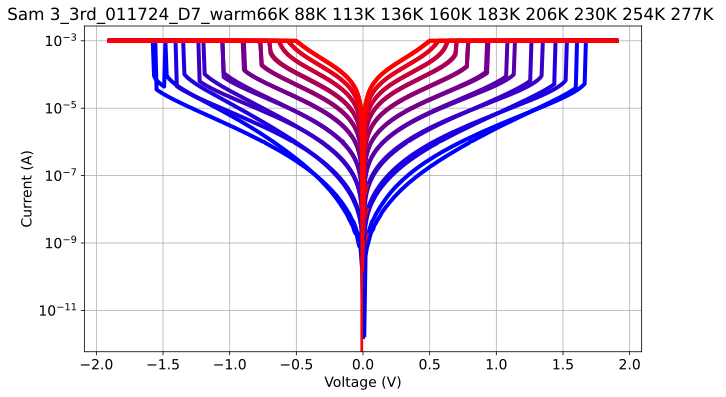

<Figure size 6000x3600 with 0 Axes>

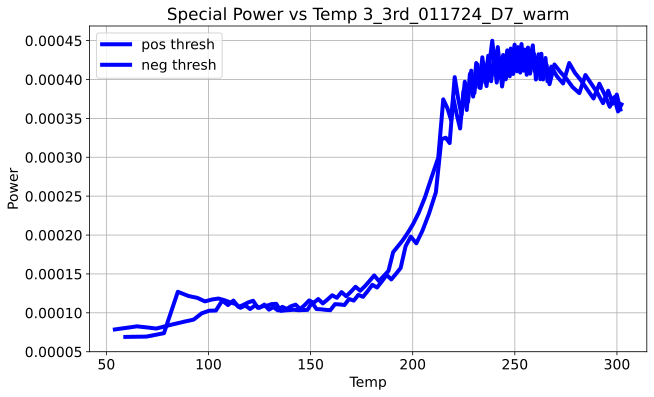

<Figure size 6000x3600 with 0 Axes>

In [331]:
theFiles = [
    DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam3_3rd_011724_D7_cool.txt"),
    DataFile(os.getcwd() + "/summerData/IVs_NbO2_Ti0_Sam3_3rd_011724_D7_warm.txt"),
]


for file in theFiles:
    # file.graph_all_data()
    # file.graph_log_r_vs_1_over_temp_by_voltage()
    file.overlay_IV_curves(10)
    file.graph_special_power_vs_temp()
    # file.graph_delta_v_vs_time()

    # file.graph_log_r_vs_1_over_temp()
    # file.graph_combined_log_r_vs_1_over_temp()

    # file.graph_combined_log_r_vs_1_over_temp_vs_p("current")
    # file.graph_combined_log_r_vs_1_over_temp_vs_p("voltage")
    

    # file.graph_DV_DI_vs_I()
    # file.graph_dR_vs_I()
    # file.graph_lowest_voltage_resistance()
    # file.graph_voltage_vs_resistance_half_volt()
    # file.graph_time_vs_I()
    # file.graph_delta_v_vs_temp()
    # file.graph_voltage_vs_temp_type()
    # file.graph_power_vs_temp()

    # file.graph_log_r_vs_voltage()
    # file.graph_r_vs_log_i()
    # file.graph_R_vs_T_constant_P()

    
    # file.graph_voltage_vs_temp()
    # data_to_graph.append(file.return_voltage_vs_temp())
    # file.graph_voltage_vs_temp()






# def animate(i):

#     x = []
#     y = []
    
#     normal_i = i
#     i = i * (int)(len(theFile.IV_curves) / 100)

#     print("progress ", i, "/", len(theFile.IV_curves))

#     points_to_graph = []

#     # print("range: ", len(theFile.IV_curves[0]['V'] - 1))
#     for index in range(len(theFile.IV_curves[i]['V']) - 1):

#         four_curves_x = [
#             theFile.IV_curves[i + 0]['V'].tolist(),
#             theFile.IV_curves[i + 1]['V'].tolist(),
#             theFile.IV_curves[i + 2]['V'].tolist(),
#             theFile.IV_curves[i + 3]['V'].tolist(),
#             ]
        
#         four_curves_y = [
#             theFile.IV_curves[i + 0]['I'].tolist(),
#             theFile.IV_curves[i + 1]['I'].tolist(),
#             theFile.IV_curves[i + 2]['I'].tolist(),
#             theFile.IV_curves[i + 3]['I'].tolist(),
#             ]
        
#         fine_tune = 0
#         index_to_graph = [
#             theFile.IV_curves[i + 0]['max_ddI'] + fine_tune,
#             theFile.IV_curves[i + 1]['max_ddI'] + fine_tune,
#             theFile.IV_curves[i + 2]['max_ddI'] + fine_tune,
#             theFile.IV_curves[i + 3]['max_ddI'] + fine_tune,
#             ]
        
#         points_to_graph = [
#             [theFile.IV_curves[i + 0]['V'][index_to_graph[0]], theFile.IV_curves[i + 0]['I'][index_to_graph[0]]],
#             [theFile.IV_curves[i + 1]['V'][index_to_graph[1]], theFile.IV_curves[i + 1]['I'][index_to_graph[1]]],
#             [theFile.IV_curves[i + 2]['V'][index_to_graph[2]], theFile.IV_curves[i + 2]['I'][index_to_graph[2]]],
#             [theFile.IV_curves[i + 3]['V'][index_to_graph[3]], theFile.IV_curves[i + 3]['I'][index_to_graph[3]]],
#         ]
        
#         # voltage = self.IV_curves[index + i]['V']
#         # current = self.IV_curves[index + i]['I']
#         # data_to_graph.append([voltage, current])

#         # fine_tune = 0
#         # type_of_data = self.IV_curves[index + i]['type_of_data']
#         # if type_of_data == "posThresh":
#         #     fine_tune = 1
#         # if type_of_data == "negThresh":
#         #     fine_tune = 1
#         # if type_of_data == "posHold":
#         #     fine_tune = -2
#         # if type_of_data == "negHold":
#         #     fine_tune = -2
        
#         # index_to_graph = self.IV_curves[index + i]['max_ddI'] + fine_tune
#         # points_to_graph.append([voltage[index_to_graph], current[index_to_graph]])
        
        
        
        
        
#         # print("V: ", four_curves_x)
#         # print("sum: ", sum(four_curves_x, []))
        
#         x.append(sum(four_curves_x, []))
#         y.append(sum(four_curves_y, []))

#         # print("type:", sum(x, []))



#         # 'time': self.time[start:stop],
#         # 'I': self.I[start:stop],
#         # 'dI': dI,
#         # 'ddI': ddI,
#         # 'V': self.V[start:stop],
#         # 'temps': self.temps[start:stop],
#         # 'temp': run_temp,
#         # 'temp_std': run_temp_std,
#         # 'type_of_data': sort_into_side(self.V[start:stop], self.I[start:stop]),
#         # 'max_ddI': np.argmax(ddI),


#         # print("points_to_graph: ", points_to_graph)
#         # for point in points_to_graph:
#         #     plt.plot(point[0], point[1], marker="o", markersize=10, markeredgecolor='red', markerfacecolor='red')
    
#     title_time = "  Time =" + str(round(theFile.IV_curves[i]['time'][0])) + " s"
#     title_temp = "  Temp =" + str(round(theFile.IV_curves[i]['temp'])) + " K" + " Std: " + str(round(theFile.IV_curves[i]['temp_std'], 3))
#     title = "IV curve # " + str(i) + title_time + title_temp + " " + theFile.file_name
#     ax.set_title(title)
#     line.set_xdata(sum(x, []))  # update the data.
#     line.set_ydata(sum(y, []))  # update the data.
#     return line,


# # ani = animation.FuncAnimation(
# #     fig, animate, interval=50, blit=True, save_count=100)
# #                 # time between frames (ms)    number of frames
# # ani.save(theFile.file_name[:-4] + ".gif")

# # plt.show()




asdf